In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas_datareader as web
from scipy.stats import skew, kurtosis
import numpy as np
import datetime
import yfinance as yf
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings("ignore")

In [3]:
start = datetime.datetime(2014, 5, 31)
end = datetime.datetime(2024, 5, 31)

In [5]:
##Settore Tecnologico
aapl = yf.download('AAPL', start, end)
nvda = yf.download('NVDA', start, end)
##Settore Automobilistico
tsla = yf.download('TSLA', start, end)
gm = yf.download('GM', start, end)
##Settore Finanziario
jpm = yf.download('JPM', start, end)
wfc = yf.download('WFC', start, end)
##SP500
sp500 = yf.download('^GSPC', start, end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
#I DataFrame originali presentano colonne multiIndici (Price e Ticker), il che possono essere un problema al momento di manipolare i dati per quanto
#riguardano i formati di ritorno. Quindi, rimuoviamo l'indice di colonna "Ticker" che non aggiunge informazione utile se non il nome dell'azione.
aapl = aapl.xs('AAPL', axis=1, level = 'Ticker', drop_level=True)
nvda = nvda.xs('NVDA', axis=1, level = 'Ticker', drop_level=True)
tsla = tsla.xs('TSLA', axis=1, level = 'Ticker', drop_level=True)
gm = gm.xs('GM', axis=1, level = 'Ticker', drop_level=True)
jpm = jpm.xs('JPM', axis=1, level = 'Ticker', drop_level=True)
wfc = wfc.xs('WFC', axis=1, level = 'Ticker', drop_level=True)
sp500 = sp500.xs('^GSPC', axis=1, level = 'Ticker', drop_level=True)

In [9]:
#Rimuoviamo le colonne che non ci interessano particolarmente per lo studio. Ci servono solo i prezzi di chiusura dai quali partiremmo con los studio
aapl = aapl.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)
nvda = nvda.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)
tsla = tsla.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)
gm = gm.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)
jpm = jpm.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)
wfc = wfc.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)
sp500 = sp500.drop(['Open', 'Low', 'High', 'Volume'], axis = 1)

In [37]:
# Calcolo dei rendimenti logaritmici giornalieri e mensili dell'indice SP500
sp500['Rit_log_giornalieri'] = np.log(sp500['Close'] / sp500['Close'].shift(1)).dropna()

sp500_monthly = sp500['Close'].resample('M').last()
sp500_monthly_df = pd.DataFrame(sp500_monthly)
sp500_monthly_df['Rit_log_mensili'] = np.log(sp500_monthly_df['Close'] / sp500_monthly_df['Close'].shift(1)).dropna()

In [39]:
# Creo un dizionario in cui tengo memorizzato il nome dell'azione originale e il nome della variabile corrispondente da me creata.
azioni = {
    'AAPL': aapl, 
    'NVDA': nvda,
    'TSLA': tsla, 
    'GM': gm,
    'JPM': jpm,
    'WFC': wfc
}
prezzi_chiusura_giornalieri_df = pd.concat({ticker: df['Close'] for ticker, df in azioni.items()}, axis=1)

In [41]:
prezzi_chiusura_giornalieri_df

,AAPL,NVDA,TSLA,GM,JPM,WFC
Date,,,,,,
2014-06-02,19.766953,0.450631,13.646667,26.430561,40.953007,37.417187
2014-06-03,20.046478,0.448728,13.662667,26.733835,41.137978,37.417187
2014-06-04,20.275394,0.449204,13.599333,27.689161,41.197166,37.380581
2014-06-05,20.354944,0.451107,13.793333,27.499619,41.900055,37.812691
2014-06-06,20.298977,0.452773,13.878000,27.943033,42.151638,38.069000
...,...,...,...,...,...,...
2024-05-23,186.010101,103.764915,173.740005,43.298100,192.456558,58.279186
2024-05-24,189.095657,106.434036,179.240005,43.674351,196.160660,58.796741
2024-05-28,189.105606,113.863579,176.750000,42.664421,194.978073,58.083881


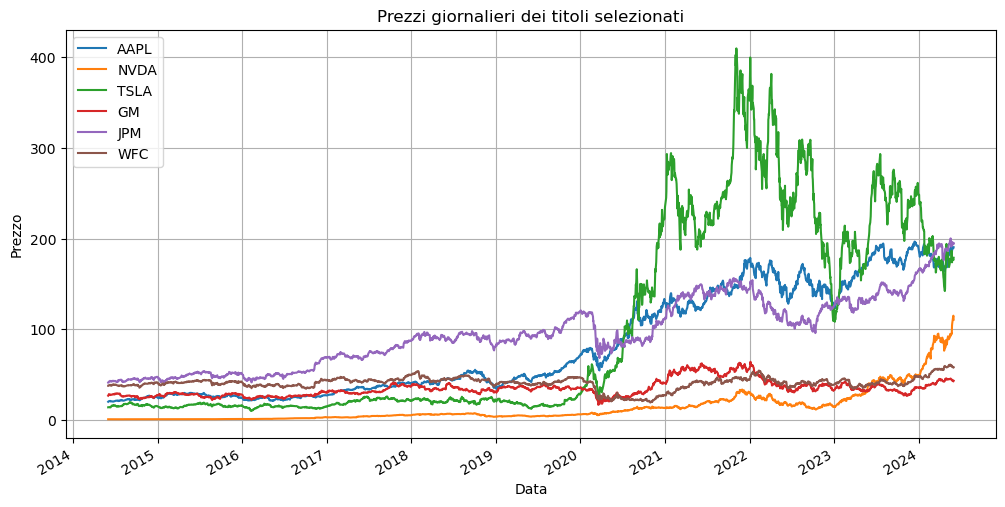

In [43]:
prezzi_chiusura_giornalieri_df.plot(figsize=(12,6))
plt.title("Prezzi giornalieri dei titoli selezionati")
plt.xlabel("Data")
plt.ylabel("Prezzo")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

In [45]:
#Calcolo del rendimenti semplici e rendimenti logaritmici GIORNALIERI
rit_semp_giornalieri = {}
rit_log_giornalieri = {}
for azione, value in azioni.items():
    rit_semp_giornalieri[azione] = value.pct_change().dropna()
    rit_log_giornalieri[azione] = np.log(value / value.shift(1)).dropna()

#Convertiamo il dizionario ritorni semplici/logaritmici giornalieri in dataframe per manipolarlo meglio
cleaned_rit_log = {azione: df['Close'] for azione, df in rit_log_giornalieri.items()}
cleaned_rit_semp = {azione: df['Close'] for azione, df in rit_semp_giornalieri.items()}
rit_log_giornalieri_df = pd.DataFrame(cleaned_rit_log)
rit_semp_giornalieri_df = pd.DataFrame(cleaned_rit_semp)

In [47]:
#Prezzi di chiusura mensili
prezzi_chiusura_mensili = {}
for azione, value in azioni.items():
    prezzi_chiusura_mensili[azione] = value.resample('ME').last()

cleaned_chiusura_mensili = {azione: df['Close'] for azione, df in prezzi_chiusura_mensili.items()}
prezzi_chiusura_mensili_df = pd.DataFrame(cleaned_chiusura_mensili)

In [49]:
#Calcolo del rendimenti semplici e rendimenti logaritmici MENSILI
rit_semp_mensili = {}
rit_log_mensili = {}
for azione, value in prezzi_chiusura_mensili.items():
    rit_semp_mensili[azione] = value.pct_change().dropna()
    rit_log_mensili[azione] = np.log(value / value.shift(1)).dropna()

#Convertiamo il dizionario ritorni semplici/logaritmici giornalieri in dataframe per manipolarlo meglio
cleaned_rit_log_mensili = {azione: df['Close'] for azione, df in rit_log_mensili.items()}
cleaned_rit_semp_mensili = {azione: df['Close'] for azione, df in rit_semp_mensili.items()}
rit_log_mensili_df = pd.DataFrame(cleaned_rit_log_mensili)
rit_semp_mensili_df = pd.DataFrame(cleaned_rit_semp_mensili)

In [51]:
#Calcolo del rendimento cumulato e rendimento composto annuo 
def calcola_rendimento_cumulato(df, colonna = 'Close'):
    prezzo_iniziale = df[colonna].iloc[0]
    prezzo_finale = df[colonna].iloc[-1]
    rendimento_cumulato = (prezzo_finale / prezzo_iniziale) - 1
    rendimento_cumulato_percentuale = rendimento_cumulato * 100
    return rendimento_cumulato_percentuale
    
for key, azione in azioni.items():
    rendimento = calcola_rendimento_cumulato(azione)
    print(f"{key}: {rendimento:.4f}%")

AAPL: 863.2217%
NVDA: 24413.0903%
TSLA: 1210.1367%
GM: 62.6196%
JPM: 375.6963%
WFC: 54.5285%


In [53]:
def calcola_rendimento_composto_annuo(df, colonna = 'Close'):
    prezzo_iniziale = df[colonna].iloc[0]
    prezzo_finale = df[colonna].iloc[-1]
    #Calcolo numero di anni (giorni_totali / 365)
    delta = end - start
    giorni_tot = delta.days
    anni = giorni_tot / 365.25 #Teniamo in considerazione gli anni bisestili (Ogni 4 anni ce n'e' uno in piu': +0.25)
    rendimento_composto_annuo = (prezzo_finale / prezzo_iniziale) ** (1 / anni) - 1
    rendimento_composto_annuo_percentuale = rendimento_composto_annuo * 100
    return rendimento_composto_annuo_percentuale

for key, azione in azioni.items():
    cagr = calcola_rendimento_composto_annuo(azione)
    print(f"{key}: {cagr:.4}%")

AAPL: 25.42%
NVDA: 73.34%
TSLA: 29.34%
GM: 4.982%
JPM: 16.88%
WFC: 4.448%


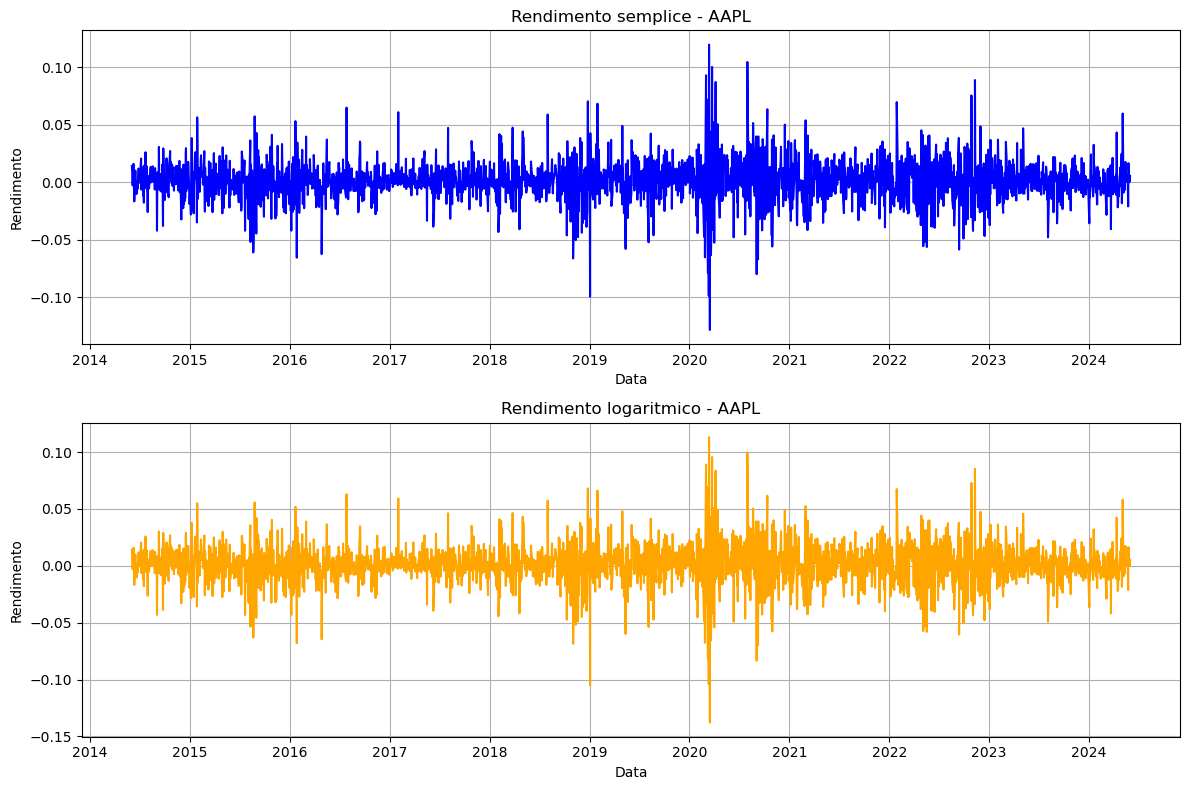

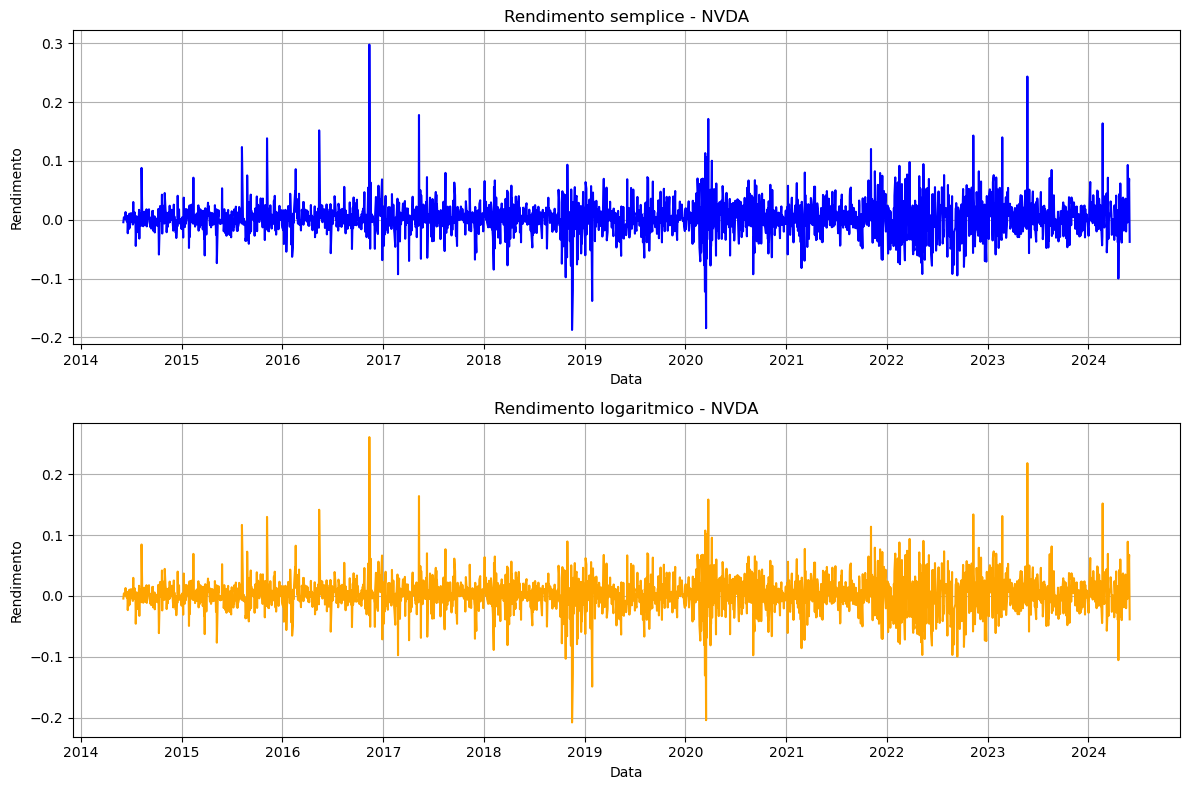

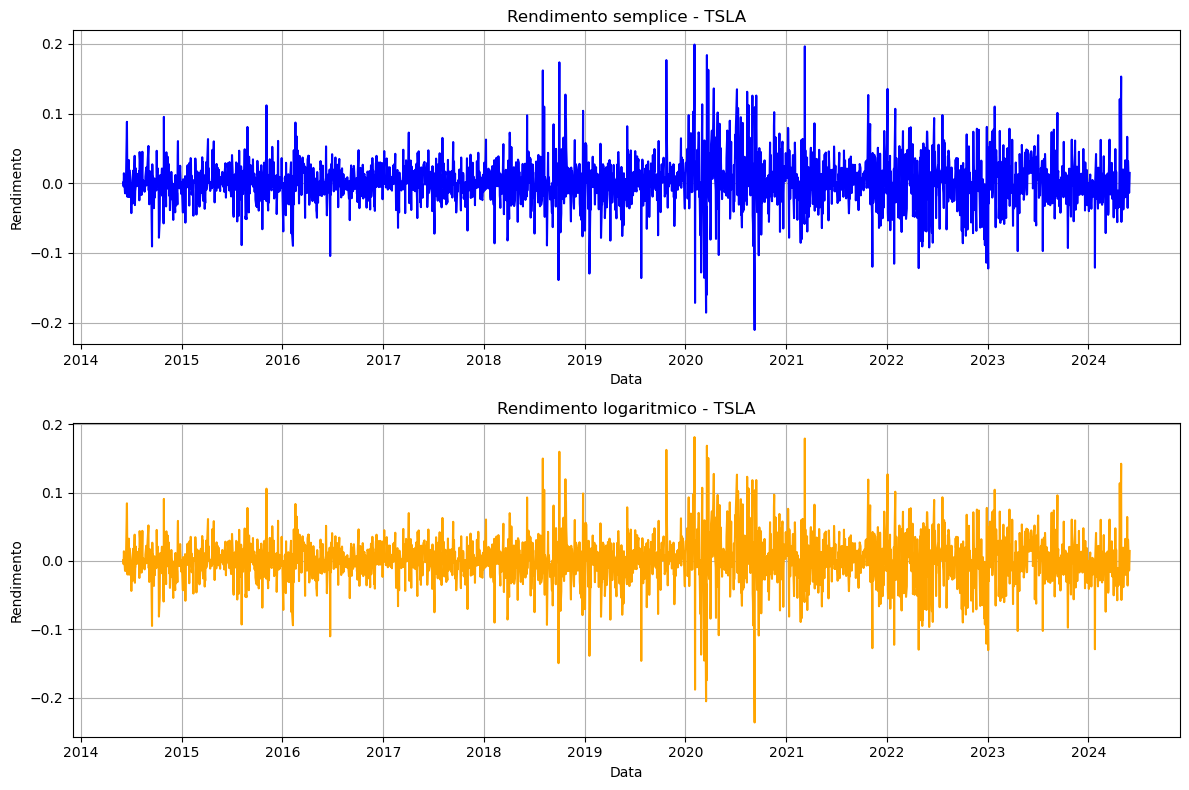

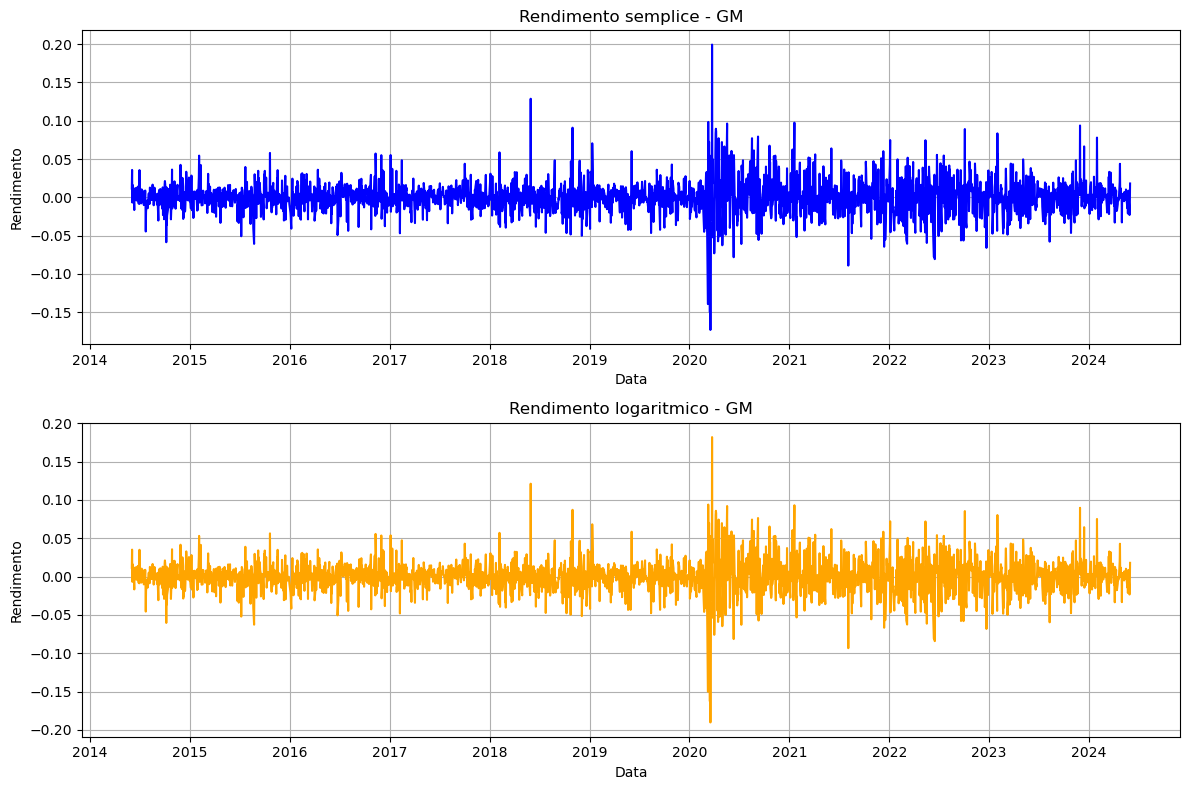

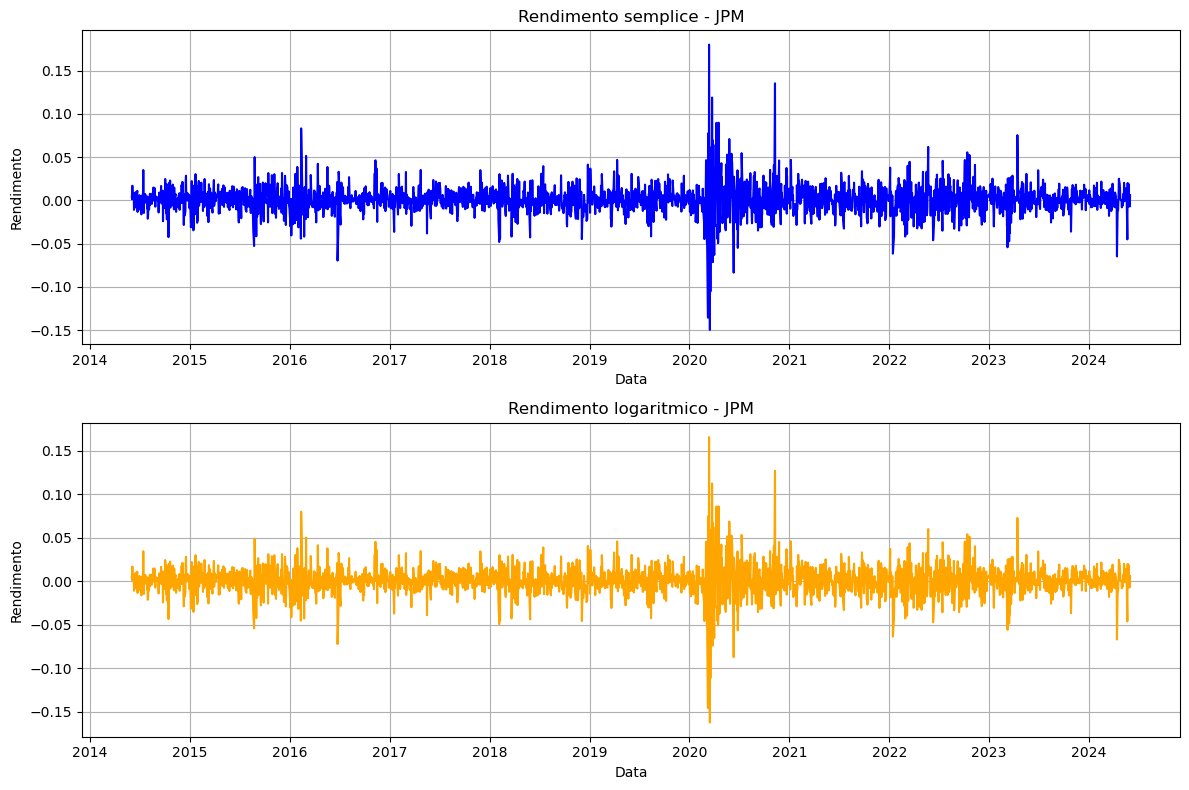

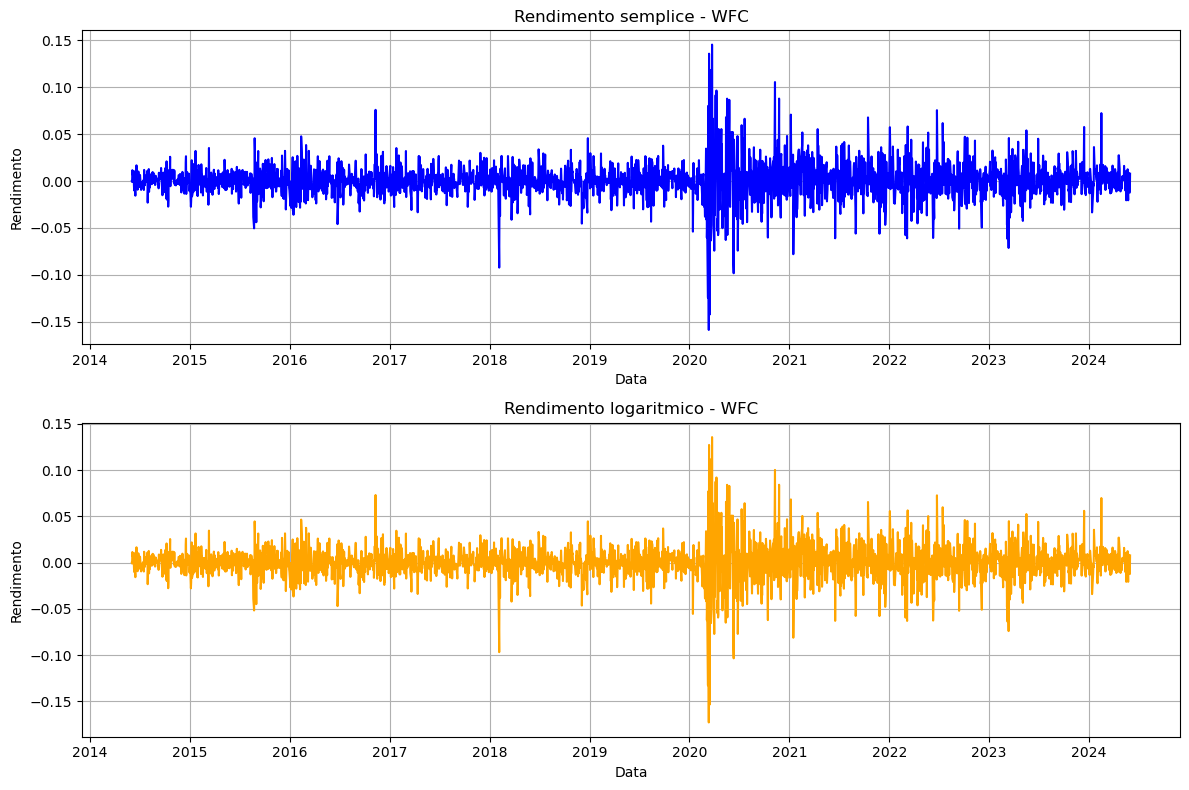

In [55]:
#Visualizzazione dei rendimenti semplici e logaritmici giornalieri 
for stock in azioni.keys():
    fig, axis = plt.subplots(2, 1, figsize = (12, 8))
    #Rendimento Semplice
    axis[0].plot(rit_semp_giornalieri[stock], color = "blue")
    axis[0].set_title(f"Rendimento semplice - {stock}")
    axis[0].set_ylabel("Rendimento")
    axis[0].set_xlabel("Data")
    axis[0].grid(True)
    #Rendimento Logaritmico
    axis[1].plot(rit_log_giornalieri[stock], color = "orange")
    axis[1].set_title(f"Rendimento logaritmico - {stock}")
    axis[1].set_ylabel("Rendimento")
    axis[1].set_xlabel("Data")
    axis[1].grid(True)
    plt.tight_layout()
    plt.show()

In [57]:
#Confrontiamo il rendimento fra societa' dello stesso settore
rit_log_tecnologia = pd.concat([rit_log_giornalieri['AAPL'], rit_log_giornalieri['NVDA']], axis = 1)
rit_log_automobili = pd.concat([rit_log_giornalieri['TSLA'], rit_log_giornalieri['GM']], axis = 1)
rit_log_banche = pd.concat([rit_log_giornalieri['JPM'], rit_log_giornalieri['WFC']], axis = 1)

rit_log_tecnologia.columns = ["AAPL", "NVDA"]
rit_log_automobili.columns = ["TSLA", "GM"]
rit_log_banche.columns = ["JPM", "WFC"]

In [59]:
display(Markdown("### Ritorni logaritmici tecnologia"))
display(rit_log_tecnologia)

display(Markdown("### Ritorni logaritmici automobili"))
display(rit_log_automobili)

display(Markdown("### Ritorni logaritmici banche"))
display(rit_log_banche)

### Ritorni logaritmici tecnologia

,AAPL,NVDA
Date,,
2014-06-03,0.014042,-0.004233
2014-06-04,0.011355,0.001059
2014-06-05,0.003916,0.004229
2014-06-06,-0.002753,0.003685
2014-06-09,0.015875,0.001050
...,...,...
2024-05-23,-0.021283,0.089106
2024-05-24,0.016452,0.025398
2024-05-28,0.000053,0.067476


### Ritorni logaritmici automobili

,TSLA,GM
Date,,
2014-06-03,0.001172,0.011409
2014-06-04,-0.004646,0.035111
2014-06-05,0.014165,-0.006869
2014-06-06,0.006120,0.015996
2014-06-09,-0.013834,-0.001369
...,...,...
2024-05-23,-0.036008,-0.005473
2024-05-24,0.031166,0.008652
2024-05-28,-0.013989,-0.023396


### Ritorni logaritmici banche

,JPM,WFC
Date,,
2014-06-03,0.004506,0.000000
2014-06-04,0.001438,-0.000979
2014-06-05,0.016918,0.011493
2014-06-06,0.005986,0.006756
2014-06-09,0.007868,0.010145
...,...,...
2024-05-23,-0.007034,-0.020729
2024-05-24,0.019064,0.008841
2024-05-28,-0.006047,-0.012198


In [61]:
correlazione_tecnologia = rit_log_tecnologia.corr()
correlazione_automobili = rit_log_automobili.corr()
rit_log_banche = rit_log_banche.corr()

In [63]:
display(Markdown("### Correlazione settore Tecnologico"))
display(correlazione_tecnologia)

display(Markdown("### Correlazione settore Automobilistico"))
display(correlazione_automobili)

display(Markdown("### Correlazione settore Bancario"))
display(rit_log_banche)

### Correlazione settore Tecnologico

,AAPL,NVDA
AAPL,1.000000,0.551793
NVDA,0.551793,1.000000


### Correlazione settore Automobilistico

,TSLA,GM
TSLA,1.000000,0.334649
GM,0.334649,1.000000


### Correlazione settore Bancario

,JPM,WFC
JPM,1.000000,0.811769
WFC,0.811769,1.000000


In [65]:
## Grafici Diagnostici a 3 sezioni (Istogrammi + Kernel Density, Boxplot, QQ-Plot)

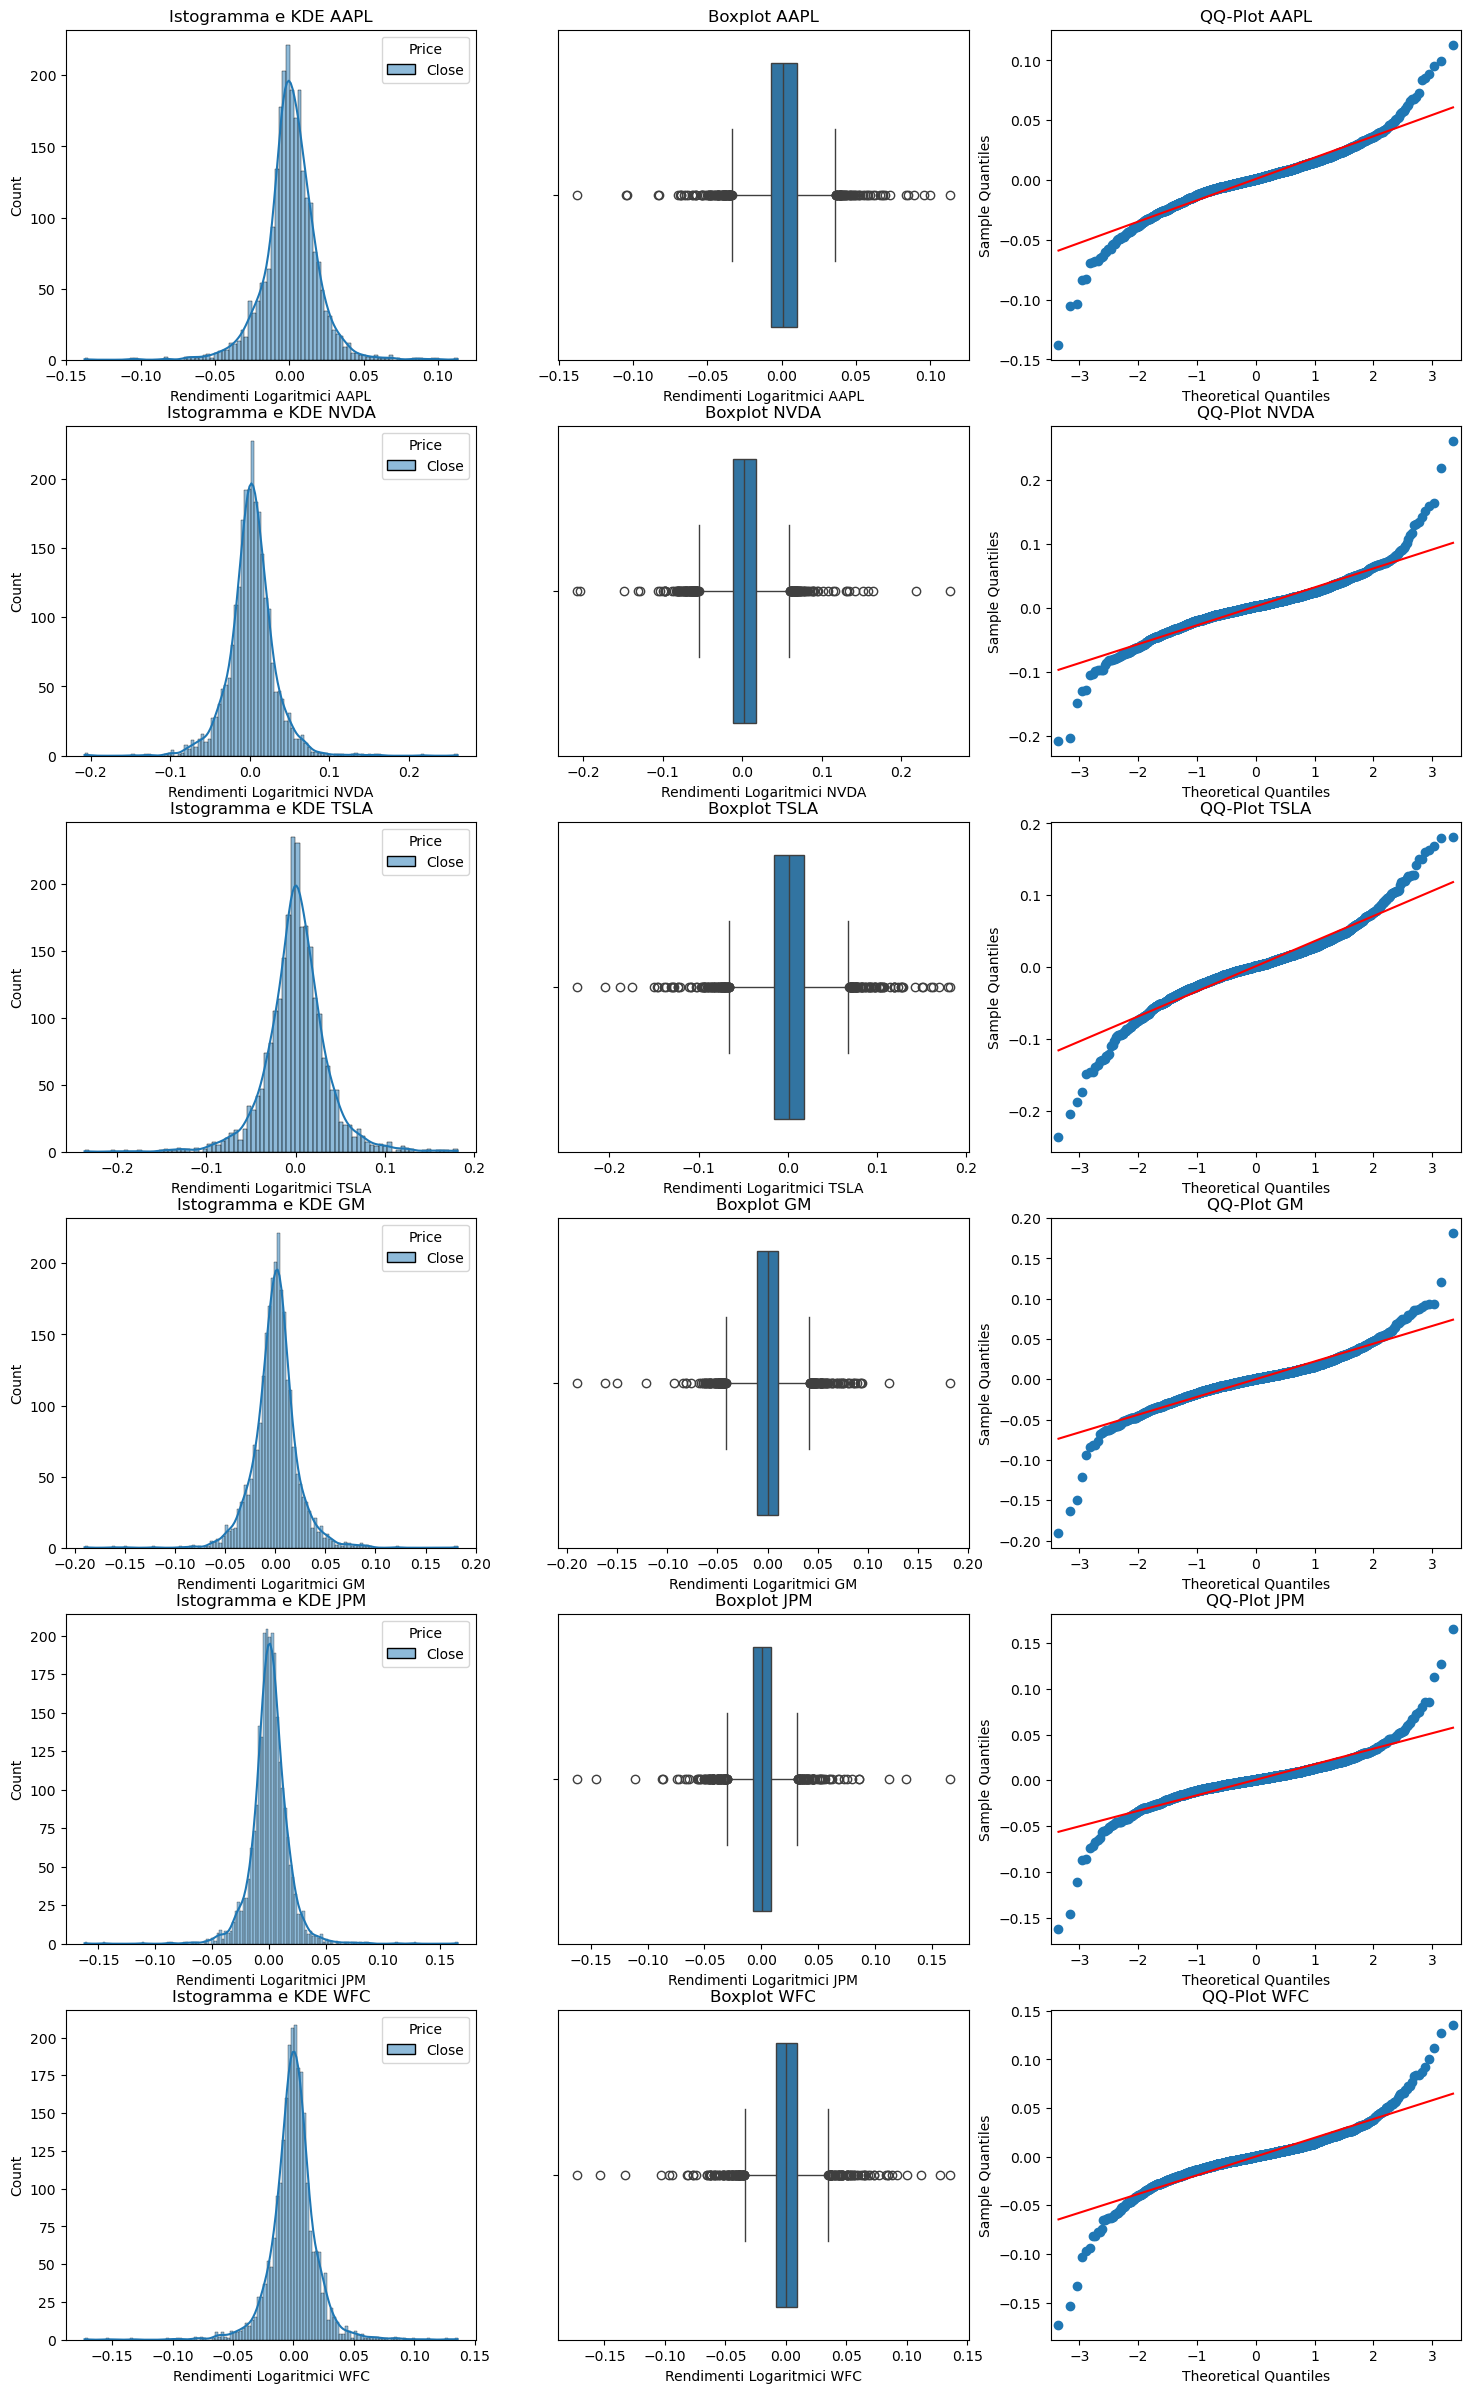

In [67]:
fig, axes = plt.subplots(6, 3, figsize = (18, 30))

for i, (stock, data) in enumerate(rit_log_giornalieri.items()):
    #Istogramma + KDE
    sns.histplot(data = data, kde = True, ax = axes[i, 0])
    axes[i, 0].set_title(f"Istogramma e KDE {stock}")
    axes[i, 0].set_xlabel(f"Rendimenti Logaritmici {stock}")
    #Boxplot
    sns.boxplot(x = data['Close'], ax = axes[i, 1])
    axes[i, 1].set_title(f"Boxplot {stock}")
    axes[i, 1].set_xlabel(f"Rendimenti Logaritmici {stock}")
    #QQ-Plot
    sm.qqplot(data['Close'], line = 's', ax = axes[i, 2])
    axes[i, 2].set_title(f"QQ-Plot {stock}")

In [69]:
##Statistiche Descrittive Univariate Anualizzate 

#Creiamo una lista per raccogliere i risultati per ogni serie di rendimenti 
statistiche_riassunto = []

for stock, data in cleaned_rit_log_mensili.items():
    mean_ann = data.mean() * 12
    var_ann = data.var() * 12
    std_ann = data.std() * np.sqrt(12)
    skewness = data.skew()
    kurt = data.kurtosis()
    #Aggiungiamo tutto in una lista
    statistiche_riassunto.append({
        'Azione': stock,
        'Media Annuale': mean_ann,
        'Varianza Annuale': var_ann,
        'Deviazione Std Annuale': std_ann,
        'Asimmetria': skewness,
        'Curtosi': kurt
    })

# Ora creiamo il DataFrame riassuntivo
riassunto_df = pd.DataFrame(statistiche_riassunto)

In [71]:
riassunto_df

,Azione,Media Annuale,Varianza Annuale,Deviazione Std Annuale,Asimmetria,Curtosi
0,AAPL,0.224968,0.075843,0.275396,-0.233385,-0.437558
1,NVDA,0.556955,0.209159,0.457340,-0.508199,0.625070
2,TSLA,0.243365,0.322536,0.567923,0.436901,0.784186
3,GM,0.044114,0.110113,0.331833,-0.302396,1.272173
4,JPM,0.153218,0.058423,0.241709,-0.482867,1.475214
5,WFC,0.041026,0.081551,0.285571,-0.703084,2.825331


In [73]:
#Ora, calcoliamo le matrici di varianze/covarianze e correlazioni:
matrice_covarianza = rit_log_mensili_df.cov()
matrice_covarianza

,AAPL,NVDA,TSLA,GM,JPM,WFC
AAPL,0.006320,0.005925,0.006770,0.003060,0.001700,0.001657
NVDA,0.005925,0.017430,0.007570,0.005196,0.003318,0.002951
TSLA,0.006770,0.007570,0.026878,0.005904,0.002515,0.003525
GM,0.003060,0.005196,0.005904,0.009176,0.004452,0.004877
JPM,0.001700,0.003318,0.002515,0.004452,0.004869,0.004589
WFC,0.001657,0.002951,0.003525,0.004877,0.004589,0.006796


In [75]:
matrice_correlazione = rit_log_mensili_df.corr()
matrice_correlazione

,AAPL,NVDA,TSLA,GM,JPM,WFC
AAPL,1.000000,0.564510,0.519401,0.401867,0.306514,0.252882
NVDA,0.564510,1.000000,0.349754,0.410871,0.360173,0.271105
TSLA,0.519401,0.349754,1.000000,0.375922,0.219841,0.260850
GM,0.401867,0.410871,0.375922,1.000000,0.666098,0.617567
JPM,0.306514,0.360173,0.219841,0.666098,1.000000,0.797769
WFC,0.252882,0.271105,0.260850,0.617567,0.797769,1.000000


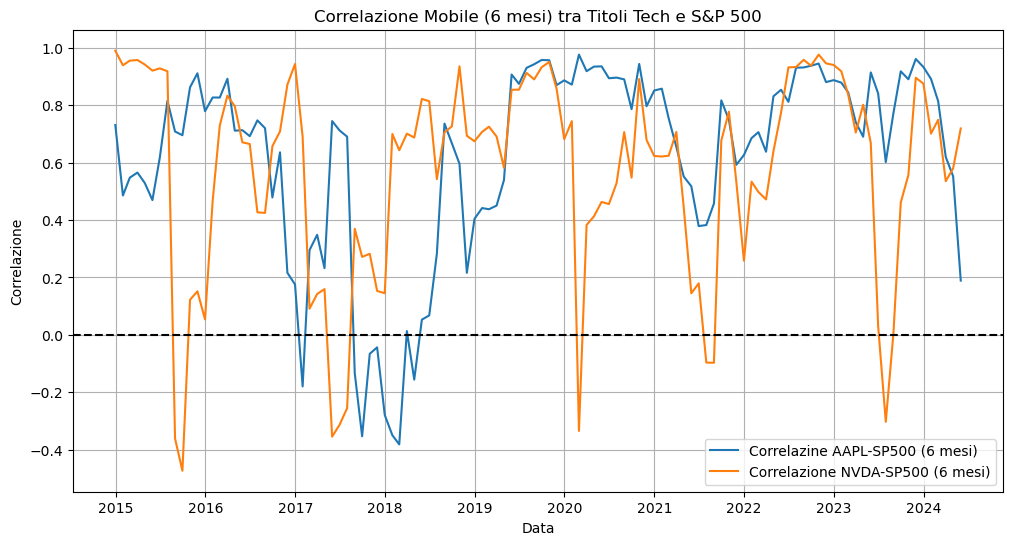

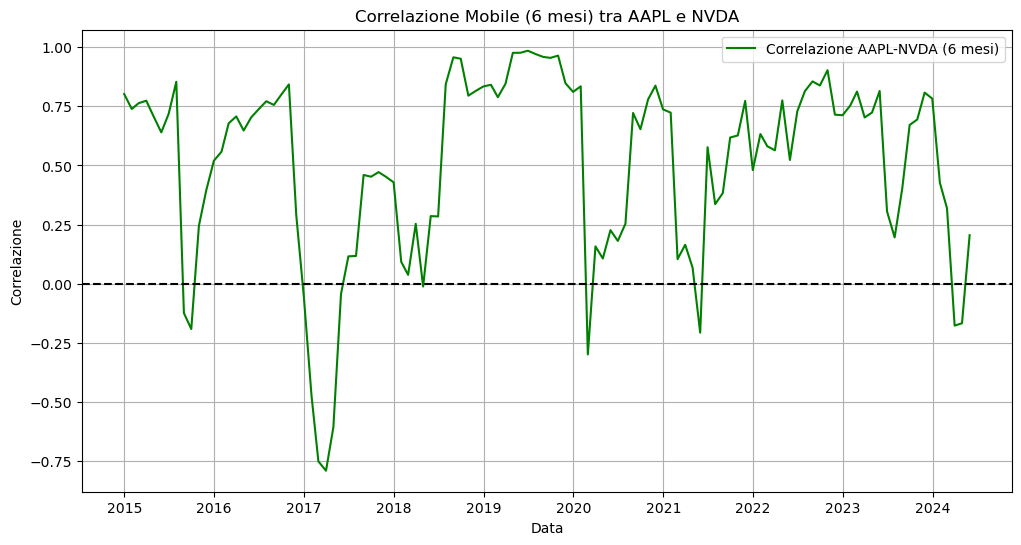

In [107]:
correlazione_temporale_aapl_nvda = rit_log_mensili_df['AAPL'].rolling(window = 6).corr(rit_log_mensili_df['NVDA'])
correlazione_temporale_aapl = rit_log_mensili_df['AAPL'].rolling(window=6).corr(sp500_monthly_df['Rit_log_mensili'])
correlazione_temporale_nvda = rit_log_mensili_df['NVDA'].rolling(window=6).corr(sp500_monthly_df['Rit_log_mensili'])

plt.figure(figsize = (12, 6))
plt.plot(correlazione_temporale_aapl, label='Correlazine AAPL-SP500 (6 mesi)')
plt.plot(correlazione_temporale_nvda, label='Correlazione NVDA-SP500 (6 mesi)')
plt.axhline(0, color = 'black', linestyle = '--')
plt.title('Correlazione Mobile (6 mesi) tra Titoli Tech e S&P 500')
plt.xlabel('Data')
plt.ylabel('Correlazione')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(correlazione_temporale_aapl_nvda, label = 'Correlazione AAPL-NVDA (6 mesi)', color = 'green')
plt.axhline(0, color = 'black', linestyle = '--')
plt.title('Correlazione Mobile (6 mesi) tra AAPL e NVDA')
plt.xlabel('Data')
plt.ylabel('Correlazione')
plt.legend()
plt.grid(True)
plt.show()

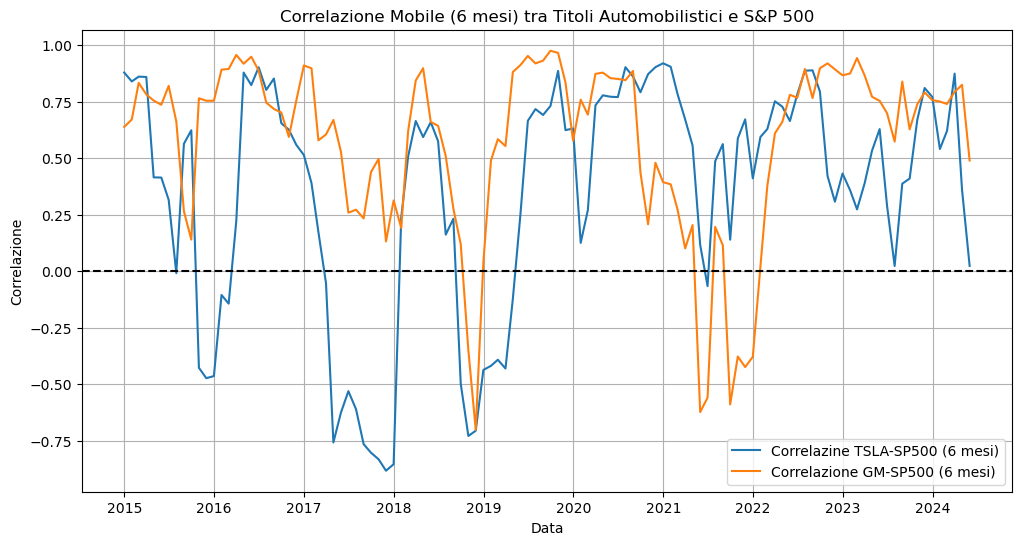

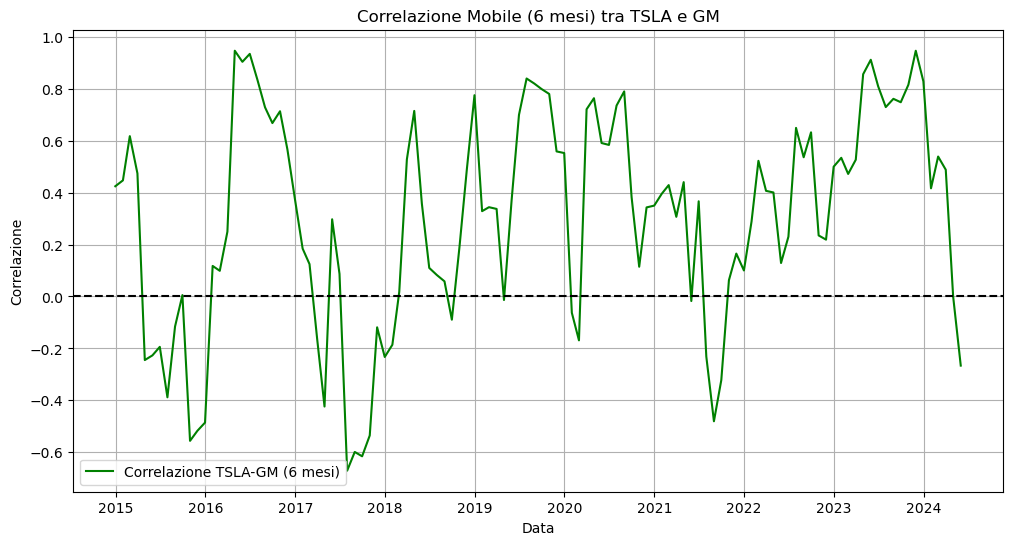

In [109]:
correlazione_temporale_tsla_gm = rit_log_mensili_df['TSLA'].rolling(window = 6).corr(rit_log_mensili_df['GM'])
correlazione_temporale_tsla = rit_log_mensili_df['TSLA'].rolling(window=6).corr(sp500_monthly_df['Rit_log_mensili'])
correlazione_temporale_gm = rit_log_mensili_df['GM'].rolling(window=6).corr(sp500_monthly_df['Rit_log_mensili'])

plt.figure(figsize = (12, 6))
plt.plot(correlazione_temporale_tsla, label='Correlazine TSLA-SP500 (6 mesi)')
plt.plot(correlazione_temporale_gm, label='Correlazione GM-SP500 (6 mesi)')
plt.axhline(0, color = 'black', linestyle = '--')
plt.title('Correlazione Mobile (6 mesi) tra Titoli Automobilistici e S&P 500')
plt.xlabel('Data')
plt.ylabel('Correlazione')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(correlazione_temporale_tsla_gm, label = 'Correlazione TSLA-GM (6 mesi)', color = 'green')
plt.axhline(0, color = 'black', linestyle = '--')
plt.title('Correlazione Mobile (6 mesi) tra TSLA e GM')
plt.xlabel('Data')
plt.ylabel('Correlazione')
plt.legend()
plt.grid(True)
plt.show()

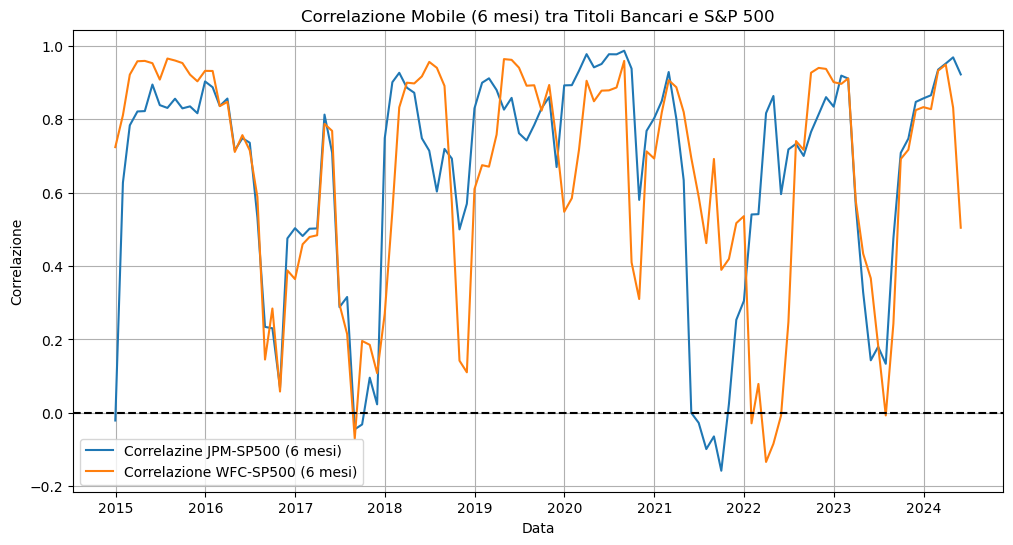

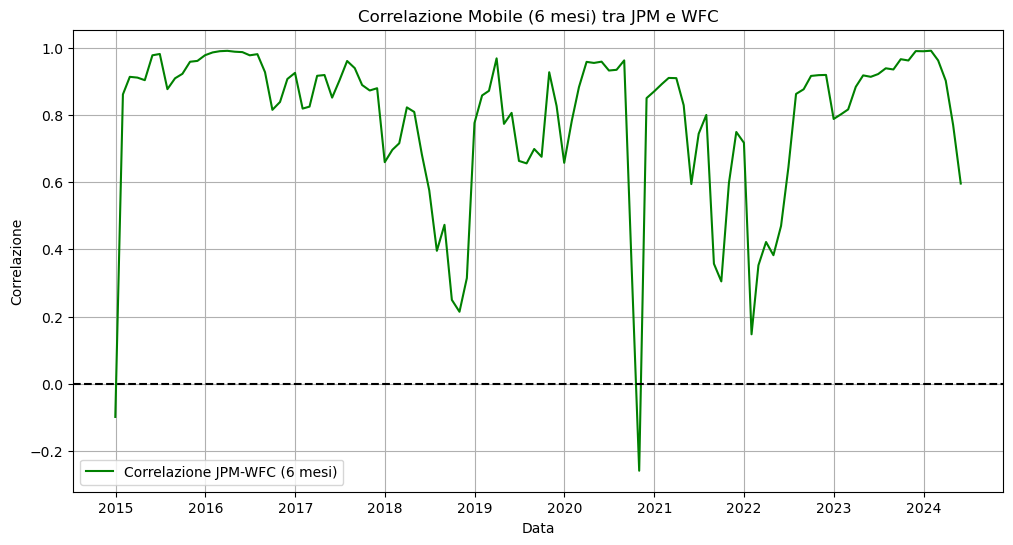

In [111]:
correlazione_temporale_jpm_wfc = rit_log_mensili_df['JPM'].rolling(window = 6).corr(rit_log_mensili_df['WFC'])
correlazione_temporale_jpm = rit_log_mensili_df['JPM'].rolling(window=6).corr(sp500_monthly_df['Rit_log_mensili'])
correlazione_temporale_wfc = rit_log_mensili_df['WFC'].rolling(window=6).corr(sp500_monthly_df['Rit_log_mensili'])

plt.figure(figsize = (12, 6))
plt.plot(correlazione_temporale_jpm, label='Correlazine JPM-SP500 (6 mesi)')
plt.plot(correlazione_temporale_wfc, label='Correlazione WFC-SP500 (6 mesi)')
plt.axhline(0, color = 'black', linestyle = '--')
plt.title('Correlazione Mobile (6 mesi) tra Titoli Bancari e S&P 500')
plt.xlabel('Data')
plt.ylabel('Correlazione')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(correlazione_temporale_jpm_wfc, label = 'Correlazione JPM-WFC (6 mesi)', color = 'green')
plt.axhline(0, color = 'black', linestyle = '--')
plt.title('Correlazione Mobile (6 mesi) tra JPM e WFC')
plt.xlabel('Data')
plt.ylabel('Correlazione')
plt.legend()
plt.grid(True)
plt.show()

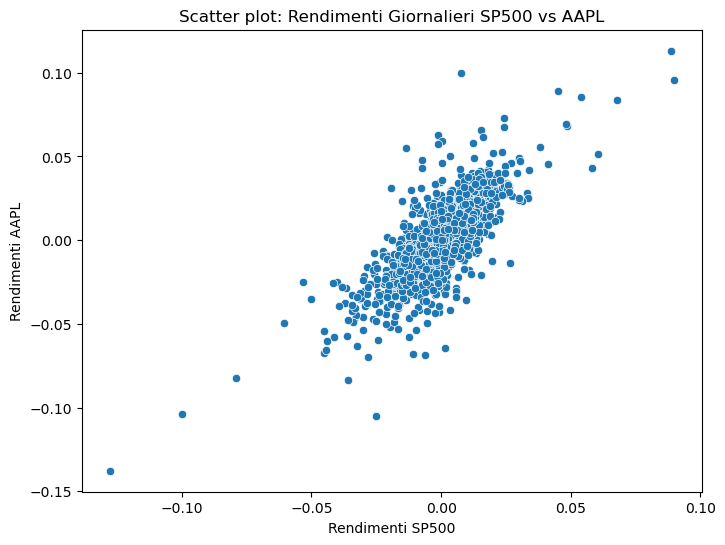

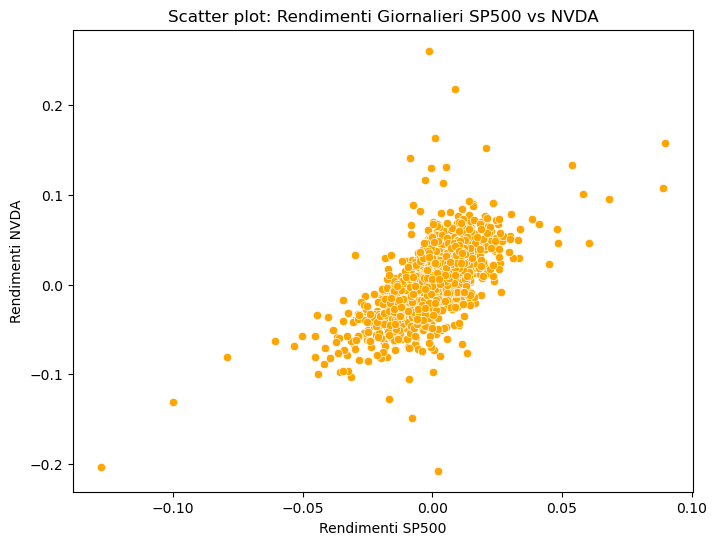

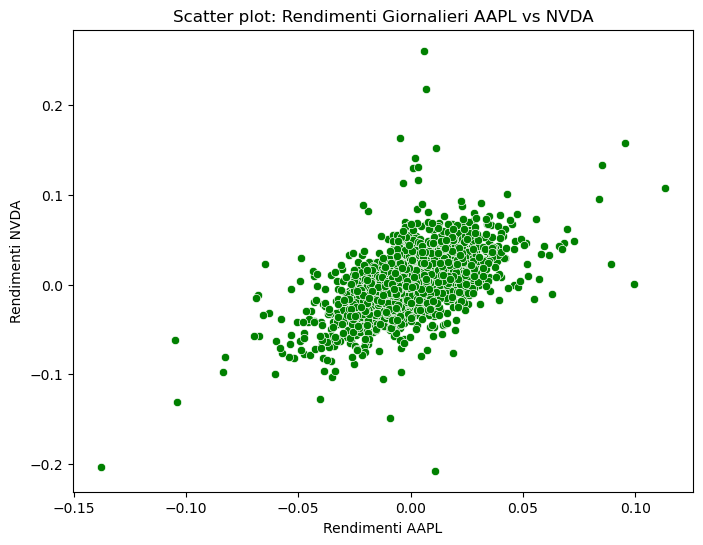

In [113]:
#Grafici di dispersione
plt.figure(figsize=(8,6))
sns.scatterplot(x = sp500['Rit_log_giornalieri'], y = rit_log_giornalieri_df['AAPL'])
plt.title('Scatter plot: Rendimenti Giornalieri SP500 vs AAPL')
plt.xlabel('Rendimenti SP500')
plt.ylabel('Rendimenti AAPL')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x = sp500['Rit_log_giornalieri'], y = rit_log_giornalieri_df['NVDA'], color = 'orange')
plt.title('Scatter plot: Rendimenti Giornalieri SP500 vs NVDA')
plt.xlabel('Rendimenti SP500')
plt.ylabel('Rendimenti NVDA')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x = rit_log_giornalieri_df['AAPL'], y = rit_log_giornalieri_df['NVDA'], color = 'green')
plt.title('Scatter plot: Rendimenti Giornalieri AAPL vs NVDA')
plt.xlabel('Rendimenti AAPL')
plt.ylabel('Rendimenti NVDA')
plt.show()

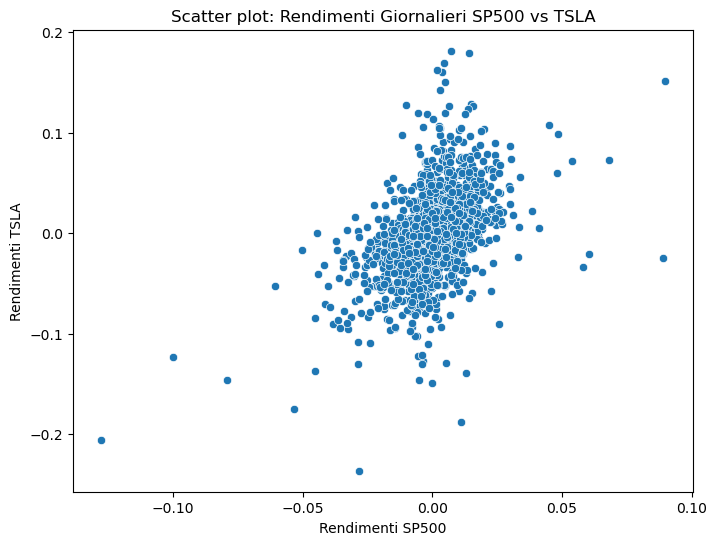

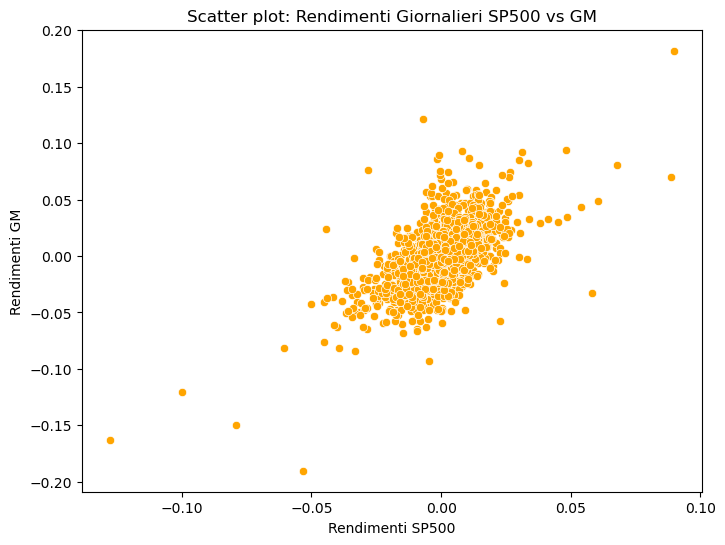

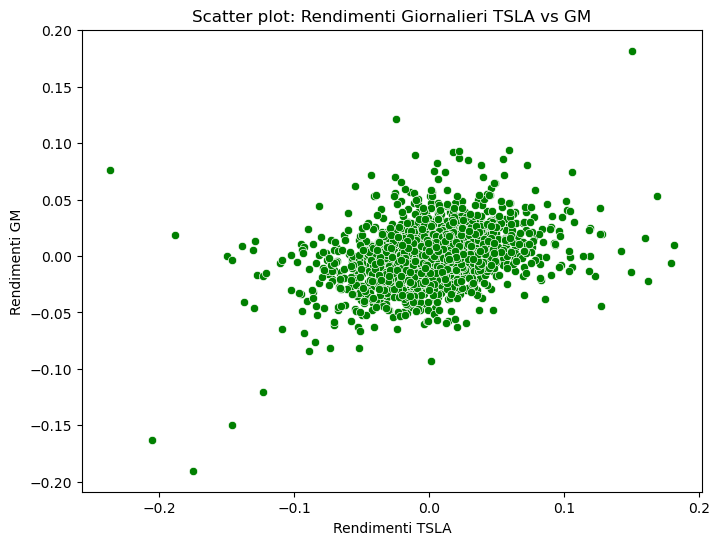

In [115]:
#Grafici di dispersione
plt.figure(figsize=(8,6))
sns.scatterplot(x = sp500['Rit_log_giornalieri'], y = rit_log_giornalieri_df['TSLA'])
plt.title('Scatter plot: Rendimenti Giornalieri SP500 vs TSLA')
plt.xlabel('Rendimenti SP500')
plt.ylabel('Rendimenti TSLA')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x = sp500['Rit_log_giornalieri'], y = rit_log_giornalieri_df['GM'], color = 'orange')
plt.title('Scatter plot: Rendimenti Giornalieri SP500 vs GM')
plt.xlabel('Rendimenti SP500')
plt.ylabel('Rendimenti GM')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x = rit_log_giornalieri_df['TSLA'], y = rit_log_giornalieri_df['GM'], color = 'green')
plt.title('Scatter plot: Rendimenti Giornalieri TSLA vs GM')
plt.xlabel('Rendimenti TSLA')
plt.ylabel('Rendimenti GM')
plt.show()

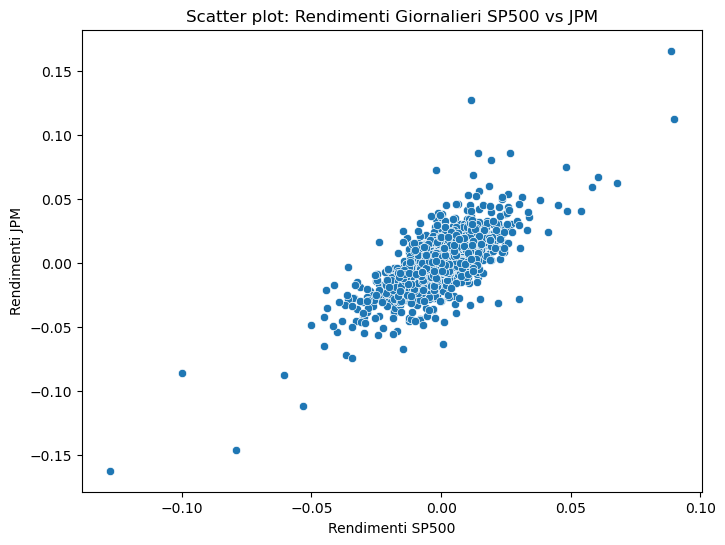

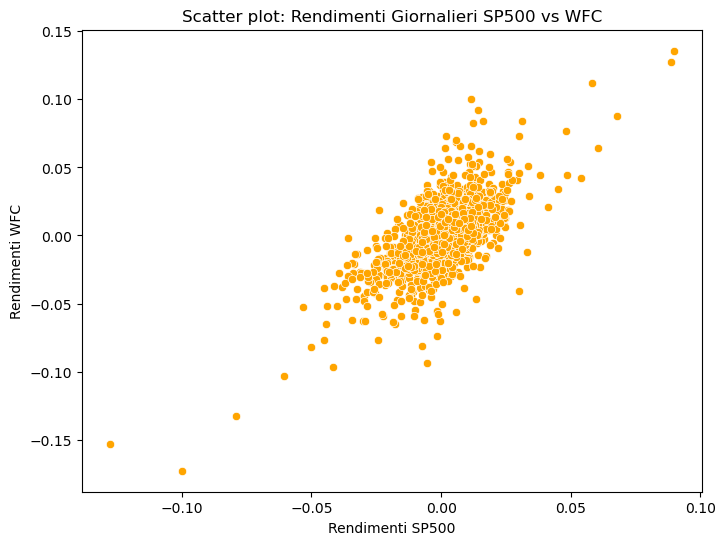

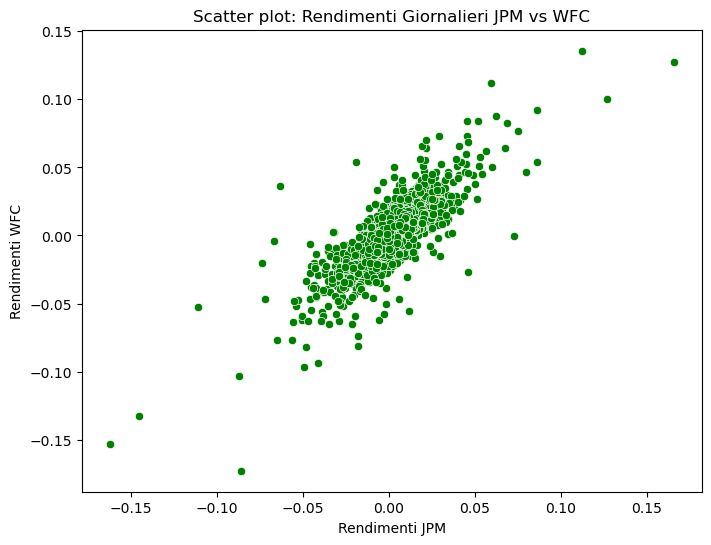

In [117]:
#Grafici di dispersione
plt.figure(figsize=(8,6))
sns.scatterplot(x = sp500['Rit_log_giornalieri'], y = rit_log_giornalieri_df['JPM'])
plt.title('Scatter plot: Rendimenti Giornalieri SP500 vs JPM')
plt.xlabel('Rendimenti SP500')
plt.ylabel('Rendimenti JPM')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x = sp500['Rit_log_giornalieri'], y = rit_log_giornalieri_df['WFC'], color = 'orange')
plt.title('Scatter plot: Rendimenti Giornalieri SP500 vs WFC')
plt.xlabel('Rendimenti SP500')
plt.ylabel('Rendimenti WFC')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x = rit_log_giornalieri_df['JPM'], y = rit_log_giornalieri_df['WFC'], color = 'green')
plt.title('Scatter plot: Rendimenti Giornalieri JPM vs WFC')
plt.xlabel('Rendimenti JPM')
plt.ylabel('Rendimenti WFC')
plt.show()

In [227]:
#3. Analisi di Previsione 
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Parametri
n = 80 #mesi
m = 30 #mesi
l = 10 #mesi

In [241]:
prezzi_chiusura_mensili_df

,AAPL,NVDA,TSLA,GM,JPM,WFC
Date,,,,,,
2014-06-30,20.454308,0.441114,16.004000,27.751902,42.632553,38.493782
2014-07-31,21.041986,0.416370,14.886667,25.855906,42.967834,37.278038
2014-08-31,22.672922,0.464813,17.980000,26.605133,44.294052,37.936974
2014-09-30,22.285826,0.440915,16.178667,24.632318,44.882648,38.254105
2014-10-31,23.889521,0.466963,16.113333,24.215862,45.365063,39.153847
...,...,...,...,...,...,...
2024-01-31,183.059418,61.503906,187.289993,38.303329,169.419662,48.382240
2024-02-29,179.664948,79.082298,201.880005,40.575260,180.788147,53.974884
2024-03-31,170.450562,90.326317,175.789993,44.902103,194.624664,56.276024



--- Elaborazione per: AAPL ---
Miglior modello di ARIMA per AAPL: (2, 2, 1)


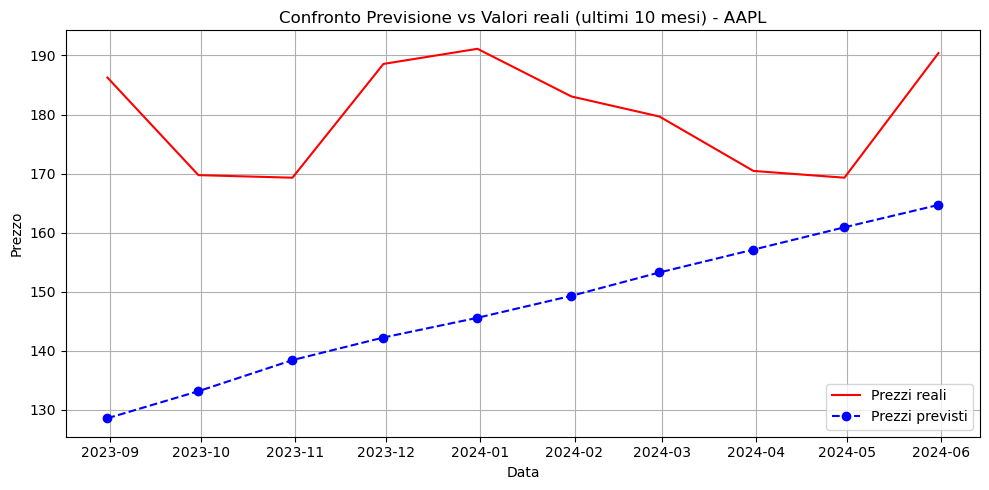

MAE: 32.4583
RMSE: 35.4735

--- Elaborazione per: NVDA ---
Miglior modello di ARIMA per NVDA: (0, 1, 1)


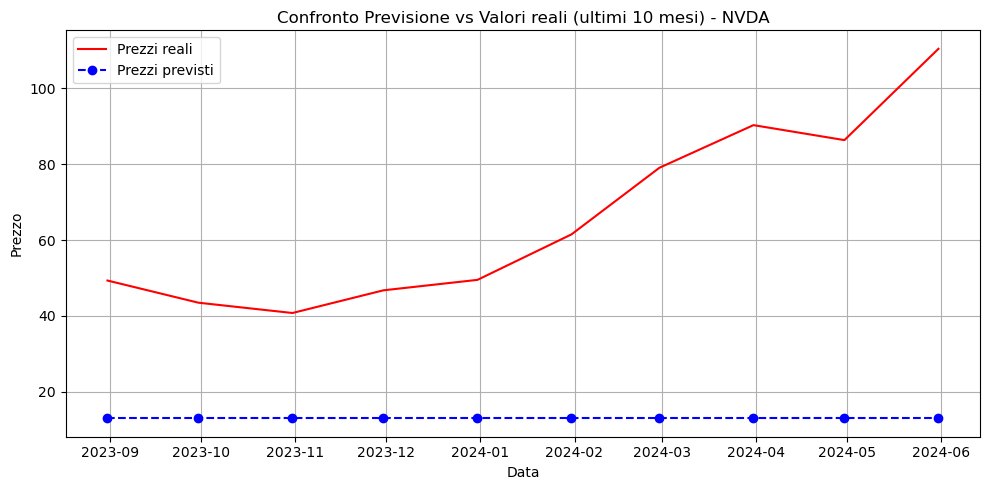

MAE: 52.7624
RMSE: 57.5137

--- Elaborazione per: TSLA ---
Miglior modello di ARIMA per TSLA: (3, 2, 3)


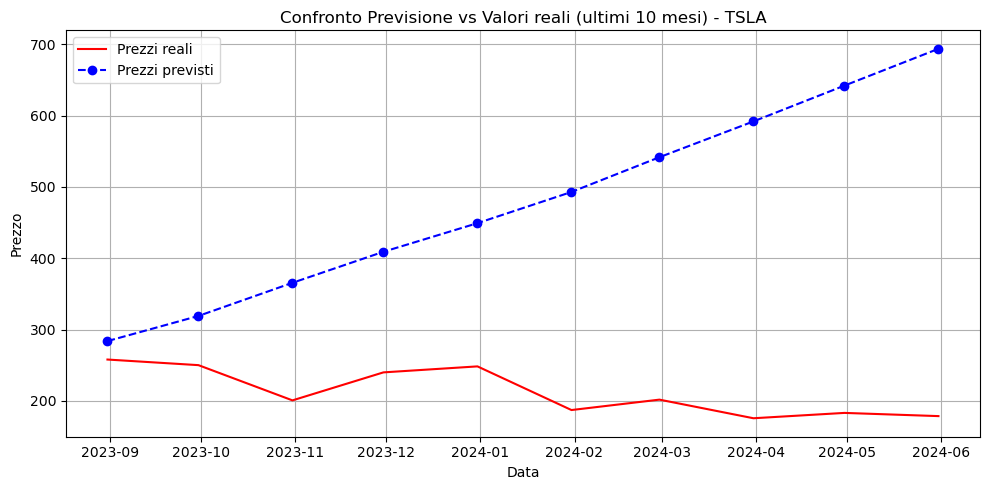

MAE: 266.4295
RMSE: 309.6477

--- Elaborazione per: GM ---
Miglior modello di ARIMA per GM: (0, 1, 0)


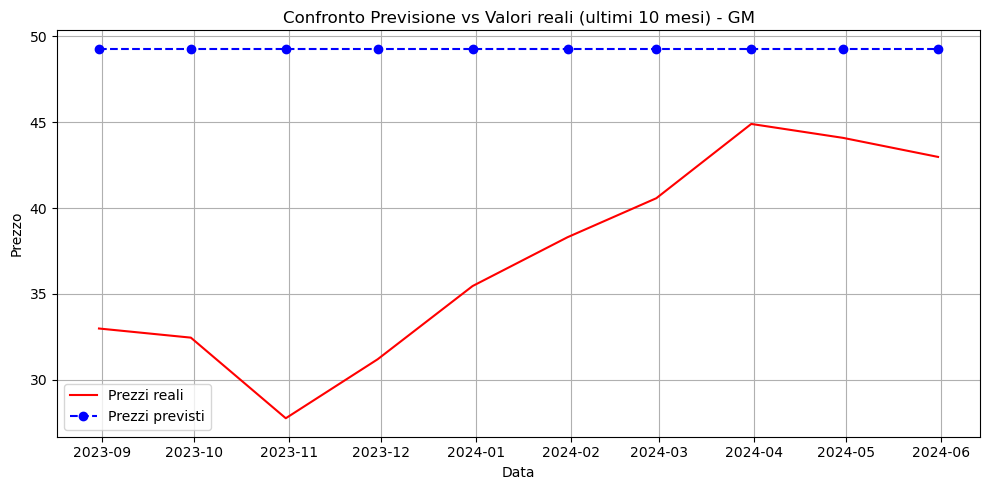

MAE: 12.2075
RMSE: 13.4587

--- Elaborazione per: JPM ---
Miglior modello di ARIMA per JPM: (0, 1, 0)


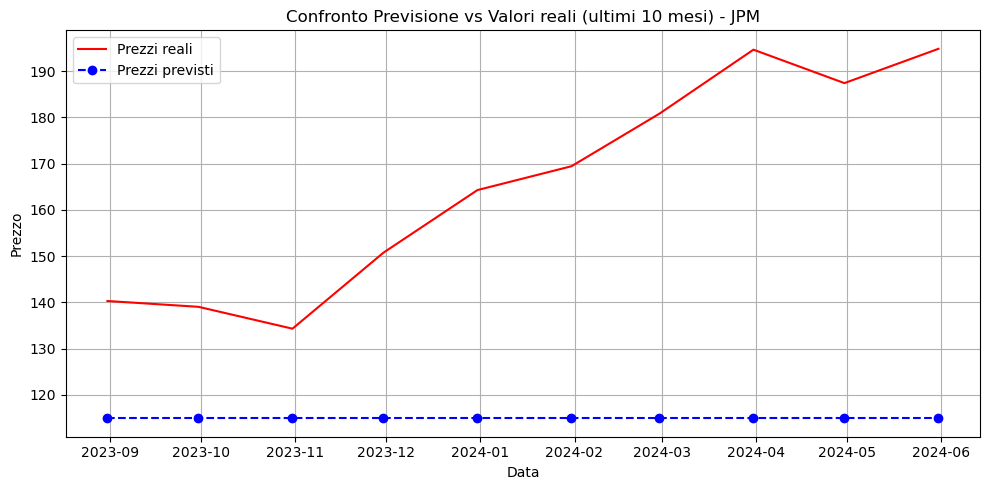

MAE: 50.6367
RMSE: 55.3241

--- Elaborazione per: WFC ---
Miglior modello di ARIMA per WFC: (1, 1, 1)


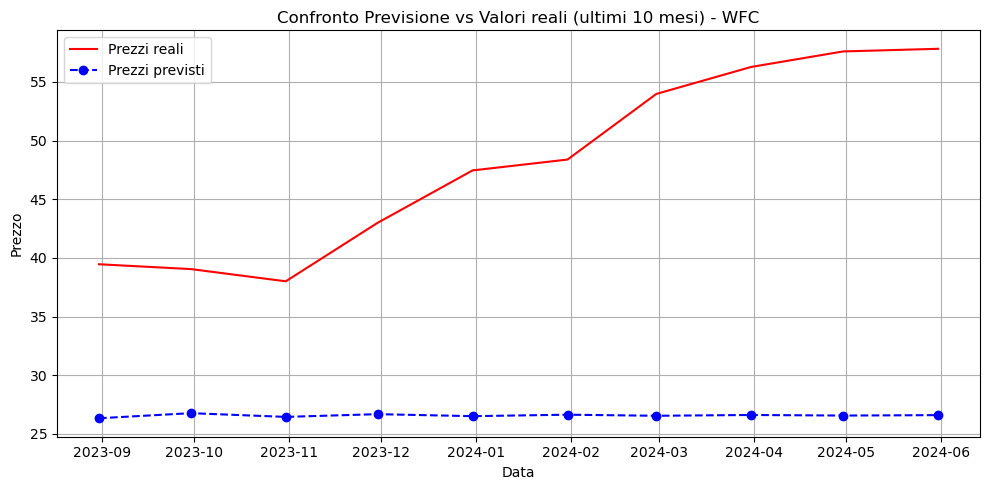

MAE: 21.5292
RMSE: 22.8112


In [239]:
# Risultati da salvare
risultati = []

for ticker in azioni:
    print(f"\n--- Elaborazione per: {ticker} ---")

    ts = prezzi_chiusura_mensili_df[ticker]
    trainset = ts[:n]
    testset = ts[n:n + m]
    real_forecast = ts[n + m: n + m + l]

    # Trova il miglior modello ARIMA
    arima_model = auto_arima(trainset, trace=False, suppress_warnings=True, stepwise=True)
    print(f"Miglior modello di ARIMA per {ticker}: {arima_model.order}")
    
    # Fitta il modello ARIMA trovato
    model = ARIMA(trainset, order=arima_model.order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=l)

    # Plot previsione vs reale
    plt.figure(figsize=(10, 5))
    plt.plot(real_forecast.index, real_forecast, label = "Prezzi reali", color='red')
    plt.plot(real_forecast.index, forecast, label = "Prezzi previsti", color='blue', linestyle="--", marker='o')
    plt.title(f'Confronto Previsione vs Valori reali (ultimi 10 mesi) - {ticker}')
    plt.xlabel("Data")
    plt.ylabel("Prezzo")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Metriche di errore
    mae = mean_absolute_error(real_forecast, forecast)
    rmse = np.sqrt(mean_squared_error(real_forecast, forecast))
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Salva risultati
    risultati.append({
        'Ticker': ticker,
        'ARIMA_order': arima_model.order,
        'MAE': mae,
        'RMSE': rmse
    })

In [235]:
risultati_df = pd.DataFrame(risultati)
risultati_df

,Ticker,ARIMA_order,MAE,RMSE
0,AAPL,"(2, 2, 1)",32.458321,35.473483
1,NVDA,"(0, 1, 1)",52.762408,57.513723
2,TSLA,"(3, 2, 3)",266.429531,309.647683
3,GM,"(0, 1, 0)",12.207488,13.458656
4,JPM,"(0, 1, 0)",50.636731,55.324121
5,WFC,"(1, 1, 1)",21.529150,22.811240


In [111]:
#Strategie di trading e backtesting - Analisi tecnica

In [113]:
aapl['Return'] = aapl['Close'].pct_change(1)
results = []
sharpe_buyhold = aapl['Return'].mean() / aapl['Return'].std() * np.sqrt(252)
for short in range(10, 101, 10):
    for long in range(50, 301, 10):
        if short >= long:
            continue

        aapl['MA_short'] = aapl['Close'].rolling(window=short).mean()
        aapl['MA_long'] = aapl['Close'].rolling(window=long).mean()

        aapl['Signal'] = 0
        aapl.loc[aapl['MA_short'] > aapl['MA_long'], 'Signal'] = 1
        aapl.loc[aapl['MA_short'] < aapl['MA_long'], 'Signal'] = -1  

        aapl['Strategy_Return'] = aapl['Signal'].shift(1) * aapl['Return']
        
        sharpe_strategy = aapl['Strategy_Return'].mean() / aapl['Strategy_Return'].std() * np.sqrt(252)
        results.append({
            'short': short,
            'long': long,
            'sharpe': sharpe_strategy
        })

In [115]:
results

[{'short': 10, 'long': 50, 'sharpe': 0.257121035944091},
 {'short': 10, 'long': 60, 'sharpe': 0.30799960237754564},
 {'short': 10, 'long': 70, 'sharpe': 0.27044468663954785},
 {'short': 10, 'long': 80, 'sharpe': 0.30419026472815275},
 {'short': 10, 'long': 90, 'sharpe': 0.1505586160486341},
 {'short': 10, 'long': 100, 'sharpe': -0.005745843353245384},
 {'short': 10, 'long': 110, 'sharpe': 0.04267355052383432},
 {'short': 10, 'long': 120, 'sharpe': 0.045819027305530224},
 {'short': 10, 'long': 130, 'sharpe': 0.05091246371799344},
 {'short': 10, 'long': 140, 'sharpe': 0.16783496531117564},
 {'short': 10, 'long': 150, 'sharpe': 0.19879292629911322},
 {'short': 10, 'long': 160, 'sharpe': 0.17790900640059465},
 {'short': 10, 'long': 170, 'sharpe': 0.23324651718263503},
 {'short': 10, 'long': 180, 'sharpe': 0.2998738155692648},
 {'short': 10, 'long': 190, 'sharpe': 0.45792744167476324},
 {'short': 10, 'long': 200, 'sharpe': 0.5191457099355143},
 {'short': 10, 'long': 210, 'sharpe': 0.5629372

In [117]:
best_result = max(results, key=lambda x: x['sharpe'])
best_result

{'short': 100, 'long': 300, 'sharpe': 0.6696783865510522}

In [119]:
sharpe_buyhold

0.943026362667236

In [121]:
#Strategia scelta: Crossover delle medie mobili 

#Media mobile breve (100gg) e lungo (300gg)
aapl['SMA_100'] = aapl['Close'].rolling(window = 100).mean()
aapl['SMA_300'] = aapl['Close'].rolling(window = 300).mean()
#Crea segnali 
aapl['Signal'] = 0
aapl.loc[aapl['SMA_100'] > aapl['SMA_300'], 'Signal'] = 1
aapl.loc[aapl['SMA_100'] < aapl['SMA_300'], 'Signal'] = -1
# Calcola rendimento strategia
aapl['Return'] = aapl['Close'].pct_change(1)
aapl['Strategy_Return'] = aapl['Signal'].shift(1) * aapl['Return']
# Valore cumulato
aapl['Strategy_Value'] = (1 + aapl['Strategy_Return']).cumprod()
aapl['Buy_Hold_Value'] = (1 + aapl['Return']).cumprod()

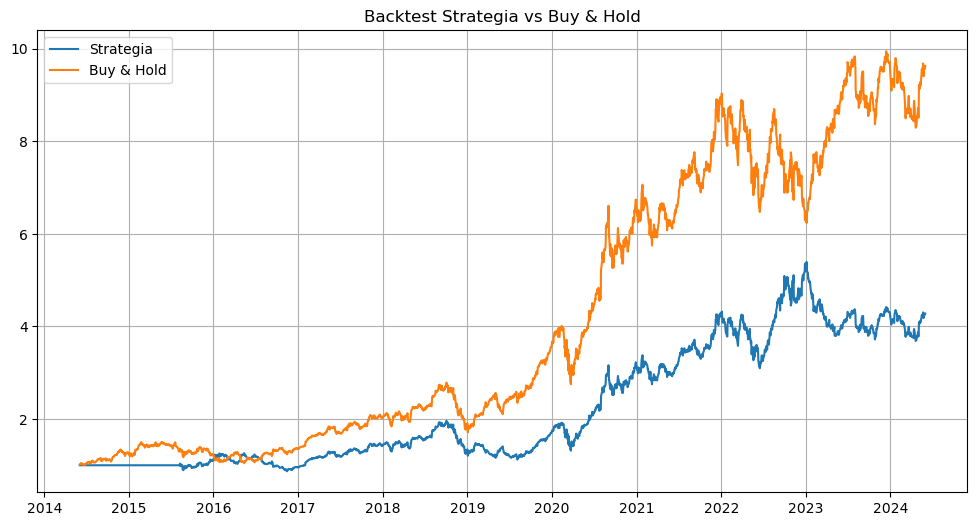

In [123]:
plt.figure(figsize=(12,6))
plt.plot(aapl['Strategy_Value'], label='Strategia')
plt.plot(aapl['Buy_Hold_Value'], label='Buy & Hold')
plt.legend()
plt.title('Backtest Strategia vs Buy & Hold')
plt.grid(True)
plt.show()

In [125]:
##CAPM

In [127]:
#Per questa sezione dobbiamo usare i prezzi di chiusura mensili e i rendimenti semplici mensili 
#Per stimare Beta e Alpha nel Capital Asset Pricing Model (CAPM) bisogna applicare una regressione lineare
#Regressione lineare --> (Ri - Rf) = alpha + Beta(Rm - Rf) + eps
#(Ri - Rf) = y --> Rendimento in eccesso dell'azione 
#(Rm - Rf) = X --> Rendimento in eccesso del mercato
#Rf --> Tasso privo di Risk-Free 
#Ri --> Rendimento dell'azione 
#Rm --> Rendimento del mercato 

In [129]:
#Secondo il tasso T-Bill USA 1 anno e' 4.11% annuale che dobbiamo dividere in 12 mesi --> 0.3425%
risk_free = 0.003425

In [131]:
#Per il rendimento atteso del mercato possiamo prendere la media storica negli ultimi decenni dell'indice SP500 pari al 8% annuo divisi in 12 mesi --> 0.6667%
market_return = 0.006667

In [133]:
rit_semp_mensili_df

,AAPL,NVDA,TSLA,GM,JPM,WFC
Date,,,,,,
2014-07-31,0.028731,-0.056095,-0.069816,-0.068319,0.007865,-0.031583
2014-08-31,0.077509,0.116345,0.207792,0.028977,0.030865,0.017676
2014-09-30,-0.017073,-0.051414,-0.100185,-0.074152,0.013289,0.008360
2014-10-31,0.071960,0.059078,-0.004038,-0.016907,0.010748,0.023520
2014-11-30,0.105979,0.077725,0.011667,0.064650,-0.005291,0.032969
...,...,...,...,...,...,...
2024-01-31,-0.042227,0.242418,-0.246257,0.080178,0.031365,0.019504
2024-02-29,-0.018543,0.285809,0.077901,0.059314,0.067103,0.115593
2024-03-31,-0.051286,0.142181,-0.129235,0.106637,0.076534,0.042634


In [135]:
#Calcolo del rendimento in eccesso di SP500
sp500 = sp500.drop(['Open','High','Low','Volume'], axis = 1)
sp500_mensile = sp500.resample('ME').last()
sp500_rit_semp_mensile = sp500_mensile['Close'].pct_change().dropna()
rendimento_eccesso_mercato = sp500_rit_semp_mensile - risk_free
#Calcolo del rendimento in eccesso dell'azione
rentimento_eccesso_azione = {}
for key, value in rit_semp_mensili.items():
    rentimento_eccesso_azione[key] = value - risk_free

#X e y della regressione lineare
X = rendimento_eccesso_mercato
X1 = sm.add_constant(X)
#Dizionari per salvare i valori beta e alpha 
valori_beta = {}
valori_alpha = {}
for key, value in rentimento_eccesso_azione.items():
    y = value
    model = sm.OLS(y,X1)
    results = model.fit()
    intercept, beta = results.params
    #Salva i risultati
    valori_alpha[key] = intercept
    valori_beta[key] = beta

# Crea un DataFrame riassuntivo
risultati_beta_alpha = pd.DataFrame({
    'Alpha': valori_alpha,
    'Beta': valori_beta
})
risultati_beta_alpha

,Alpha,Beta
AAPL,0.011450,1.237935
NVDA,0.042438,1.805787
TSLA,0.020428,1.827549
GM,-0.003522,1.424642
JPM,0.005203,1.138075
WFC,-0.003409,1.153923


In [137]:
#Calcolare il rendimento atteso con CAPM 
#La formula CAPM e' --> Rendimento_atteso = Rf + Beta(R_mercato - Rf), dove Rf e' Risk-Free (tipicamente il rendimento di un T-Bill a 1 anno)

In [139]:
#Rendimento atteso azioni con la formula CAPM
for azione, beta in valori_beta.items():
    rendimento_atteso_mensile = risk_free + beta*(market_return - risk_free)
    rendimento_atteso_annuale = (rendimento_atteso_mensile * 12) * 100
    print(f"Rendimento atteso annuo {azione}: {rendimento_atteso_annuale:.3f}%")

Rendimento atteso annuo AAPL: 8.926%
Rendimento atteso annuo NVDA: 11.135%
Rendimento atteso annuo TSLA: 11.220%
Rendimento atteso annuo GM: 9.652%
Rendimento atteso annuo JPM: 8.538%
Rendimento atteso annuo WFC: 8.599%


In [141]:
#Calcolo esposizione di ogni titolo ai fattori di rischio Fama-French
import getFamaFrenchFactors as gff

In [142]:
#L'obiettivo e' stimare il modello Fama-French a 3 fattori
#Formula --> (Ri - Rf) = alpha + B1(Rm - Rf) + B2(SMB) + B3(HML) + Eps
#B1, B2 e B3: Esposizione del titolo a ciascun fattore

In [145]:
ff3_mensile = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
ff3_mensile

,date_ff_factors,Mkt-RF,SMB,HML,RF
0,1926-07-31,0.0289,-0.0255,-0.0239,0.0022
1,1926-08-31,0.0264,-0.0114,0.0381,0.0025
2,1926-09-30,0.0038,-0.0136,0.0005,0.0023
3,1926-10-31,-0.0327,-0.0014,0.0082,0.0032
4,1926-11-30,0.0254,-0.0011,-0.0061,0.0031
...,...,...,...,...,...
1180,2024-11-30,0.0649,0.0446,0.0016,0.0040
1181,2024-12-31,-0.0317,-0.0271,-0.0299,0.0037
1182,2025-01-31,0.0280,-0.0197,0.0163,0.0037
1183,2025-02-28,-0.0244,-0.0579,0.0491,0.0033


In [147]:
#Cambio nome della colonna "date_ff_factors" a "Data"
ff3_mensile.rename({'date_ff_factors': 'Data'}, axis=1, inplace=True)
#Impostiamo le date come indice del dataframe
ff3_mensile.set_index('Data', inplace = True)
ff3_mensile.head()

,Mkt-RF,SMB,HML,RF
Data,,,,
1926-07-31,0.0289,-0.0255,-0.0239,0.0022
1926-08-31,0.0264,-0.0114,0.0381,0.0025
1926-09-30,0.0038,-0.0136,0.0005,0.0023
1926-10-31,-0.0327,-0.0014,0.0082,0.0032
1926-11-30,0.0254,-0.0011,-0.0061,0.0031


In [149]:
#Dizionario per salvare i risultati
ff_risultati = {}
for azione, rendimenti in rit_semp_mensili.items():
    # Unisce con i Fama-French factors
    data = pd.concat([rit_semp_mensili_df[azione], ff3_mensile], axis = 1, join = 'inner')
    # Calcola rendimento in eccesso
    data['excess_ret'] = data[azione] - data['RF']
    # Regressori: Mkt-RF, SMB, HML
    X = data[['Mkt-RF', 'SMB', 'HML']]
    X1 = sm.add_constant(X)
    y = data['excess_ret']
    # Modello OLS
    model = sm.OLS(y, X1).fit()
    # Salva i risultati in un dizionario
    ff_risultati[azione] = {
        'alpha': model.params['const'],
        'beta_mkt': model.params['Mkt-RF'],
        'beta_smb': model.params['SMB'],
        'beta_hml': model.params['HML'],
        'r_squared': model.rsquared
    }

In [151]:
ff_risultati_df = pd.DataFrame(ff_risultati).T
ff_risultati_df

,alpha,beta_mkt,beta_smb,beta_hml,r_squared
AAPL,0.007670,1.240372,-0.214189,-0.567018,0.534990
NVDA,0.036271,1.786732,-0.087196,-0.929090,0.418068
TSLA,0.015776,1.752172,0.752151,-1.089840,0.292920
GM,-0.002548,1.268673,0.787671,0.607787,0.576462
JPM,0.005515,1.086672,0.060703,0.846210,0.747711
WFC,-0.002560,1.080529,0.139069,0.979007,0.616818


In [153]:
# Modello Fama-French a 5 fattori estende il modello a 3 fattori aggiungendo altri 2 fattori legati alla redditivita' e agli investimenti

In [129]:
ff5_mensile = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = start, end = end)[0]
ff5_mensile.index = ff5_mensile.index.to_timestamp('M')
ff5_mensile = ff5_mensile / 100
ff5_mensile

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2014-05-31,0.0204,-0.0186,-0.0010,-0.0009,-0.0096,0.0000
2014-06-30,0.0261,0.0306,-0.0071,-0.0183,-0.0191,0.0000
2014-07-31,-0.0203,-0.0420,-0.0008,0.0093,0.0051,0.0000
2014-08-31,0.0424,0.0029,-0.0057,-0.0064,-0.0069,0.0000
2014-09-30,-0.0196,-0.0366,-0.0147,0.0120,-0.0059,0.0000
...,...,...,...,...,...,...
2024-01-31,0.0073,-0.0571,-0.0238,0.0069,-0.0096,0.0047
2024-02-29,0.0507,-0.0078,-0.0343,-0.0194,-0.0214,0.0042
2024-03-31,0.0284,-0.0119,0.0416,0.0146,0.0114,0.0043


In [131]:
#Dizionario per salvare i risultati
ff5_risultati = {}
for azione, rendimenti in rit_semp_mensili.items():
    # Unisce con i Fama-French factors
    data = pd.concat([rit_semp_mensili_df[azione], ff5_mensile], axis = 1, join = 'inner')
    # Calcola rendimento in eccesso
    data['excess_ret'] = data[azione] - data['RF']
    # Regressori: Mkt-RF, SMB, HML
    X = data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X1 = sm.add_constant(X)
    y = data['excess_ret']
    # Modello OLS
    model = sm.OLS(y, X1).fit()
    # Salva i risultati in un dizionario
    ff5_risultati[azione] = {
        'alpha': model.params['const'],
        'beta_mkt': model.params['Mkt-RF'],
        'beta_smb': model.params['SMB'],
        'beta_hml': model.params['HML'],
        'beta_rmw': model.params['RMW'],
        'beta_cma': model.params['CMA'],
        'r_squared': model.rsquared
    }

In [133]:
ff5_risultati_df = pd.DataFrame(ff5_risultati).T
ff5_risultati_df

,alpha,beta_mkt,beta_smb,beta_hml,beta_rmw,beta_cma,r_squared
AAPL,0.005836,1.204027,-0.036662,-0.607959,0.574434,-0.004236,0.553900
NVDA,0.036675,1.671363,-0.243118,-0.380969,0.183708,-1.224653,0.442796
TSLA,0.017677,1.777180,0.218359,-0.808842,-0.665842,-0.597943,0.294812
GM,-0.001973,1.254134,0.673619,0.576659,-0.149596,-0.189068,0.573662
JPM,0.007872,1.079917,-0.185988,1.143891,-0.593511,-0.502843,0.788039
WFC,0.000276,1.046735,-0.143089,1.387278,-0.642473,-0.776155,0.666224


In [161]:
#Strategie di trading e backtesting – Strategie dinamiche

In [163]:
#Simuliamo, innanzitutto, la strategia CPPI sui titoli in portafoglio
#La CPPI protegge il capitale investito garantendo che il valore del portafoglio non scenda sotto un certo livello minimo (floor), e investe l'eccesso in asset rischiosi.
#All'inizio imposteremmo i pesi dei titoli in modo equo, cioe, che abbiano lo stesso peso (Equal Weigth)
#Formula --> Exposure = m x (Portfolio_Value - Floor)
# Portfolio_value - Floor --> Cushion
# m --> Moltiplicatore 

In [135]:
equal_weights = np.repeat(1/6, 6) #Pesi iniziali equi
investimento_iniziale = 100000
floor_value = 0.8 * investimento_iniziale #Protezione del capitale all'80%
safe_return = 0.02 / 252  # es. 2% annuo
moltiplicatore = 2 #A seconda del rischio che vogliamo affrontare sopra la soglia minima garantita: Piu' basso minore rischio, piu' alto maggiore rischio e maggiori rendimenti potenziali  

In [137]:
#Simulazione CPPI
cppi_risultati = []
valore_portafoglio = investimento_iniziale
account_value = investimento_iniziale

In [139]:
for date, ritorno in rit_semp_giornalieri_df.iterrows():
    cushion = max(valore_portafoglio - floor_value, 0)
    exposure = moltiplicatore * cushion
    risky_weight = min(exposure / valore_portafoglio, 1)
    safe_weight = 1 - risky_weight
    
    portfolio_ret = (risky_weight * np.dot(equal_weights, ritorno)) + (safe_weight * safe_return)
    valore_portafoglio *= (1 + portfolio_ret)
    cppi_risultati.append({'Date': date, 'Portfolio Value': valore_portafoglio, 'Risky Weight': risky_weight})

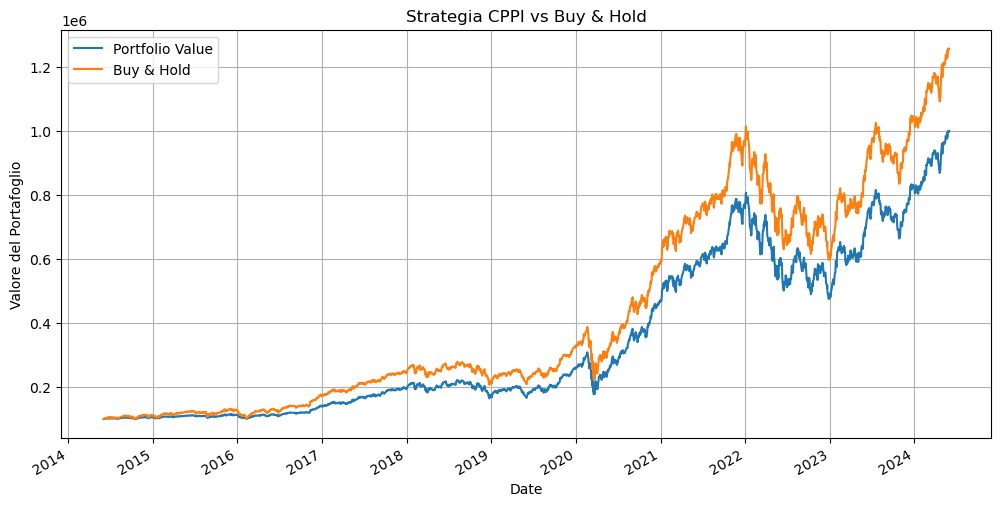

In [141]:
cppi_df = pd.DataFrame(cppi_risultati).set_index('Date')
cppi_df['Buy & Hold'] = (1 + rit_semp_giornalieri_df.dot(equal_weights)).cumprod() * investimento_iniziale

cppi_df[['Portfolio Value', 'Buy & Hold']].plot(figsize=(12,6), title="Strategia CPPI vs Buy & Hold")
plt.ylabel("Valore del Portafoglio")
plt.grid(True)
plt.show()

In [143]:
#Calcolo Drawdown massimo (perdita massima dal picco piu' alto al minimo successivo)
portfolio = cppi_df['Portfolio Value']
rolling_max = portfolio.cummax()
drawdown = (portfolio - rolling_max) / rolling_max
max_drawdown = drawdown.min()  # valore negativo (es. -0.35 → -35%)

print("Drawdown massimo:", max_drawdown)
#Sharpe Ratio
daily_returns = portfolio.pct_change().dropna()
risk_free_rate = 0.02
excess_daily_returns = daily_returns - (risk_free_rate / 252)
sharpe_ratio = (excess_daily_returns.mean() / excess_daily_returns.std()) * np.sqrt(252)
print("Sharpe Ratio:", sharpe_ratio)
#Volatilita'
volatility = daily_returns.std() * np.sqrt(252)
print("Volatilità annualizzata:", volatility)
#Performance cumulativo
cumulative_performance = (portfolio[-1] / portfolio[0]) - 1
print("Performance cumulativa:", cumulative_performance)

Drawdown massimo: -0.42443195360838043
Sharpe Ratio: 0.9595496326331516
Volatilità annualizzata: 0.25275044045641554
Performance cumulativa: 8.961561695756535


In [179]:
# Parametri iniziali
equal_weights = np.repeat(1/6, 6)  # pesi fissi per semplicità
investimento_iniziale = 100000
floor_value = 0.8 * investimento_iniziale
safe_return = 0.02 / 252
moltiplicatore = 4  # puoi testare anche 2 o 4
peso_minimo_rischioso = 0.2  # almeno il 20% in asset rischiosi

In [181]:
cppi_risultati = []
valore_portafoglio = investimento_iniziale
max_portfolio_value = investimento_iniziale

In [183]:
for date, ritorno in rit_semp_giornalieri_df.iterrows():
    # Aggiorna il massimo valore portafoglio raggiunto (protezione dei guadagni)
    max_portfolio_value = max(valore_portafoglio, max_portfolio_value)
    floor_value = 0.8 * max_portfolio_value  # Floor dinamico basato sul max

    # Calcolo cushion e allocazioni
    cushion = max(valore_portafoglio - floor_value, 0)
    exposure = moltiplicatore * cushion
    risky_weight = min(exposure / valore_portafoglio, 1)
    risky_weight = max(risky_weight, peso_minimo_rischioso)  # peso minimo garantito
    safe_weight = 1 - risky_weight

    # Allocazione ai rendimenti giornalieri
    ritorno_portafoglio = (risky_weight * np.dot(equal_weights, ritorno)) + (safe_weight * safe_return)
    valore_portafoglio *= (1 + ritorno_portafoglio)

    cppi_risultati.append({
        'Date': date,
        'Portfolio Value': valore_portafoglio,
        'Risky Weight': risky_weight
    })

# Costruzione DataFrame dei risultati
cppi_df = pd.DataFrame(cppi_risultati).set_index('Date')

# Calcolo della strategia Buy & Hold
cppi_df['Buy & Hold'] = (1 + rit_semp_giornalieri_df.dot(equal_weights)).cumprod() * investimento_iniziale

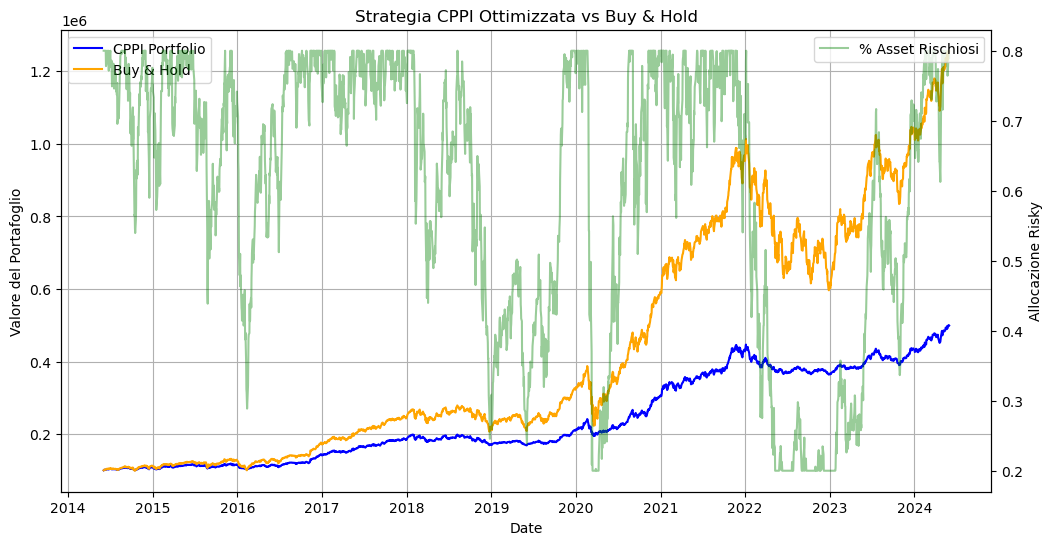

In [185]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(cppi_df['Portfolio Value'], label='CPPI Portfolio', color='blue')
ax1.plot(cppi_df['Buy & Hold'], label='Buy & Hold', color='orange')
ax1.set_ylabel('Valore del Portafoglio')
ax1.set_xlabel('Date')
ax1.legend(loc='upper left')
ax1.grid(True)

# Secondo asse per il peso dell'asset rischioso
ax2 = ax1.twinx()
ax2.plot(cppi_df['Risky Weight'], label='% Asset Rischiosi', color='green', alpha=0.4)
ax2.set_ylabel('Allocazione Risky')
ax2.legend(loc='upper right')

plt.title("Strategia CPPI Ottimizzata vs Buy & Hold")
plt.show()

In [207]:
portfolio = cppi_df['Portfolio Value']

# Drawdown massimo
rolling_max = portfolio.cummax()
drawdown = (portfolio - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Sharpe Ratio
daily_returns = portfolio.pct_change().dropna()
risk_free_rate = 0.02
daily_rfr = (1 + risk_free_rate) ** (1/252) - 1
excess_daily_returns = daily_returns - daily_rfr
sharpe_ratio = (excess_daily_returns.mean() / excess_daily_returns.std()) * np.sqrt(252)

# Volatilità annualizzata
volatility = daily_returns.std() * np.sqrt(252)

# Performance cumulativa
cumulative_performance = (portfolio.iloc[-1] / portfolio.iloc[0]) - 1

# Stampa risultati
print("Strategia CPPI")
print(f"Drawdown massimo:{max_drawdown:.4f}")
print(f"Sharpe Ratio:{sharpe_ratio:.4f}")
print(f"Volatilità annualizzata:{volatility:.4f}")
print(f"Performance cumulativa:{cumulative_performance:.4f}")

Strategia CPPI
Drawdown massimo:-0.1932
Sharpe Ratio:1.1249
Volatilità annualizzata:0.1332
Performance cumulativa:3.9731


In [209]:
portfolio = cppi_df['Buy & Hold']

# Drawdown massimo
rolling_max = portfolio.cummax()
drawdown = (portfolio - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Sharpe Ratio
daily_returns = portfolio.pct_change().dropna()
risk_free_rate = 0.02
daily_rfr = (1 + risk_free_rate) ** (1/252) - 1
excess_daily_returns = daily_returns - daily_rfr
sharpe_ratio = (excess_daily_returns.mean() / excess_daily_returns.std()) * np.sqrt(252)

# Volatilità annualizzata
volatility = daily_returns.std() * np.sqrt(252)

# Performance cumulativa
cumulative_performance = (portfolio.iloc[-1] / portfolio.iloc[0]) - 1

# Stampa risultati
print("Buy&Hold")
print(f"Drawdown massimo:{max_drawdown:.4f}")
print(f"Sharpe Ratio:{sharpe_ratio:.4f}")
print(f"Volatilità annualizzata:{volatility:.4f}")
print(f"Performance cumulativa:{cumulative_performance:.4f}")

Buy&Hold
Drawdown massimo:-0.4244
Sharpe Ratio:1.0113
Volatilità annualizzata:0.2658
Performance cumulativa:11.4905
